In [2]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp

sys.path.append("/home/sergey/tools/sclitr/")
import sclitr as sl

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

In [156]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sc.set_figure_params(dpi=150, dpi_save=300)
sns.set_style("ticks")

In [2]:
adata_NC = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/merged_clones_trunk_E13/trunk_NC_E13_clonal_clusters.h5ad")
adata_NC_pert = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_merged.h5ad")

adata_NC_pert = adata_NC_pert[adata_NC_pert.obs.celltype_l2.isin(adata_NC.obs.celltype_l2)]
adata_NC_pert = adata_NC_pert[~adata_NC_pert.obs_names.isin(adata_NC.obs_names)]

adata_NC_pert_cycling = adata_NC_pert[adata_NC_pert.obs.phase != "G1"]
adata_NC_pert_noncycling = adata_NC_pert[adata_NC_pert.obs.phase == "G1"]

sp.tl.map_embedding(adata_NC_pert_noncycling, adata_NC, key="sample_id")
sp.tl.map_embedding(adata_NC_pert_cycling, adata_NC, key="sample_id")

adata_NC_pert = adata_NC_pert_cycling.concatenate(
    adata_NC_pert_noncycling,
    index_unique=None,
    batch_key=None,
    uns_merge="first",
)

sp.tl.ingest(adata_NC_pert, adata_NC, use_rep="X_pca_harmony")

2024-04-06 02:32:25.195918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-06 02:32:25.220341: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 02:32:25.786601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-06 02:32:25.786703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-06 02:32:25.786713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

In [3]:
new_ct_mapping = {
    "Chromaffin": ["Chromaffin cells", "Chromaffin cells"],
    "Chromaffin bridge": ["Chromaffin cells", "Chromaffin cells"],
    "Melanocytes": ["Melanocytes", "Melanocytes"],
    "Glia Cxcl12": ["Nonmyelinating glia", "Glia"],
    "Glia NMJ": ["MNJ glia", "Glia"],
    "Glia Phox2b": ["Autonomic glia", "Autonomic glia"],
    "Glia Schwann": ["Myelinating glia", "Glia"],
    "Glia SCP": ["SCP", "Glia"],
    "Glia sensory BCC": ["BCC", "Sensory glia"],
    "Glia sensory satellite": ["Sensory glia", "Sensory glia"],
    "Glia sensory satellite 2": ["Sensory glia", "Sensory glia"],
    "Neuron autonomic": ["Enteric neurons", "Enteric neurons"],
    "Neuron autonomic parasympathetic": ["Parasympathetic neurons", "Autonomic neurons"],
    "Neuron autonomic sympathetic": ["Sympathetic neurons", "Autonomic neurons"],
    "Autonomic bridge": ["Enteric neurons", "Enteric neurons"],
    "Sensory 1": ["Sensory neurons", "Sensory neurons"],
    "Sensory 2": ["Sensory neurons", "Sensory neurons"],
    "Sensory 3": ["Sensory neurons", "Sensory neurons"],
    "Autonomic HOXB": ["Doublets", "Doublets"],
}

adata_NC.obs["celltype_NC_l1"] = [new_ct_mapping[i][1] for i in adata_NC.obs.celltype_l3]
adata_NC.obs["celltype_NC_l2"] = [new_ct_mapping[i][0] for i in adata_NC.obs.celltype_l3]

sc.tl.leiden(adata_NC)
adata_NC.obs["celltype_NC_l1"] = [j if i != "10" else "Doublets" for i, j in zip(adata_NC.obs.leiden, adata_NC.obs.celltype_NC_l1)]
adata_NC.obs["celltype_NC_l2"] = [j if i != "10" else "Doublets" for i, j in zip(adata_NC.obs.leiden, adata_NC.obs.celltype_NC_l2)]

sp.tl.transfer_labels_kNN(adata_NC_pert, adata_NC, "celltype_NC_l1")
sp.tl.transfer_labels_kNN(adata_NC_pert, adata_NC, "celltype_NC_l2")

adata_NC_pert = adata_NC_pert[adata_NC_pert.obs.celltype_NC_l2 != "Doublets"]
adata_NC = adata_NC[adata_NC.obs.celltype_NC_l2 != "Doublets"]
adata_NC_pert = adata_NC_pert[adata_NC_pert.obs.celltype_NC_l1 != "Doublets"]
adata_NC = adata_NC[adata_NC.obs.celltype_NC_l1 != "Doublets"]

In [5]:
l1_colors = dict(zip(
    adata_NC.obs.celltype_NC_l1.cat.categories,
    sns.color_palette("tab20")[:len(adata_NC.obs.celltype_NC_l1.cat.categories)]
))

l2_colors = dict(zip(
    adata_NC.obs.celltype_NC_l2.cat.categories,
    sns.color_palette("tab20")[:len(adata_NC.obs.celltype_NC_l2.cat.categories)]
))

adata_NC.uns["celltype_NC_l1_colors"] = [l1_colors[i] for i in adata_NC.obs.celltype_NC_l1.cat.categories]
adata_NC.uns["celltype_NC_l2_colors"] = [l2_colors[i] for i in adata_NC.obs.celltype_NC_l2.cat.categories]
adata_NC_pert.uns["celltype_NC_l1_colors"] = [l1_colors[i] for i in adata_NC_pert.obs.celltype_NC_l1.cat.categories]
adata_NC_pert.uns["celltype_NC_l2_colors"] = [l2_colors[i] for i in adata_NC_pert.obs.celltype_NC_l2.cat.categories]

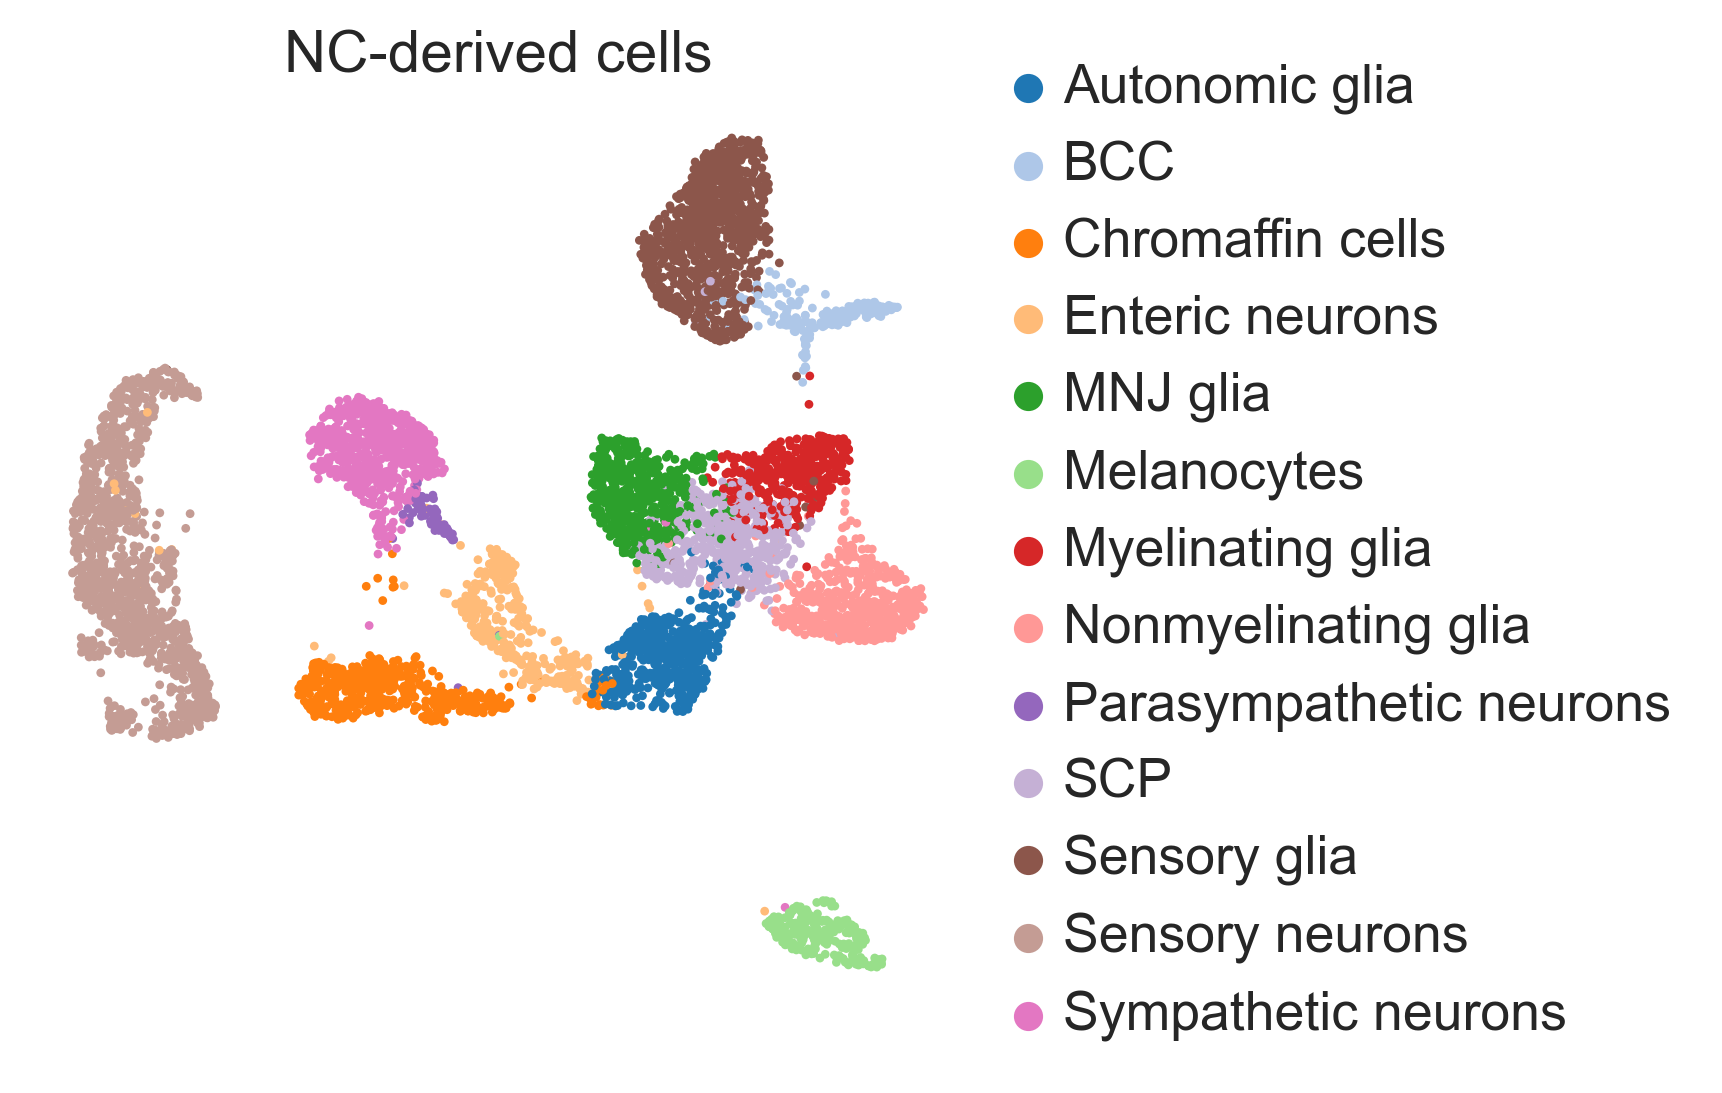

In [7]:
sc.pl.umap(adata_NC, color="celltype_NC_l2", frameon=False, title="NC-derived cells", save="NC_GEX.pdf")

In [21]:
def create_fake_anndata(adata):
    clone_ids = adata.obs[["E7.5:clones", "E8.5:clones", "celltype_NC_l2", "celltype_NC_l1", "CRISPR:predicted"]]
    clone_ids["E7.5:clones"] = [f"E7.5:{i}" if i != "NA" else "NA" for i in clone_ids["E7.5:clones"]]
    clone_ids["E8.5:clones"] = [f"E8.5:{i}" if i != "NA" else "NA" for i in clone_ids["E8.5:clones"]]
    double_clones = clone_ids[(clone_ids["E7.5:clones"] != "NA") & (clone_ids["E8.5:clones"] != "NA")]
    double_clones_cells = double_clones.index
    single_clones = clone_ids[~clone_ids.index.isin(double_clones.index)]

    single_clones["clones"] = (
        single_clones["E7.5:clones"] * (single_clones["E7.5:clones"] != "NA") +
        single_clones["E8.5:clones"] * (single_clones["E8.5:clones"] != "NA")
    ).replace("", "NA")
    del (single_clones["E7.5:clones"], single_clones["E8.5:clones"])

    double_clones = pd.concat([
        pd.DataFrame(np.matrix(double_clones.values[:, [0, 2, 3]]), index=double_clones.index + "_0",  columns=double_clones.columns[[0, 2, 3]]),
        pd.DataFrame(np.matrix(double_clones.values[:, [0, 2, 3]]), index=double_clones.index + "_1",  columns=double_clones.columns[[1, 2, 3]])
    ]).fillna("NA")

    double_clones["clones"] = (
        double_clones["E7.5:clones"] * (double_clones["E7.5:clones"] != "NA") +
        double_clones["E8.5:clones"] * (double_clones["E8.5:clones"] != "NA")
    ).replace("", "NA")
    del (double_clones["E7.5:clones"], double_clones["E8.5:clones"])

    return sc.AnnData(
        obsm={
            "X_pca_harmony": np.concatenate([
                np.array(adata[single_clones.index].obsm["X_pca_harmony"]),
                np.array(adata[double_clones_cells].obsm["X_pca_harmony"]),
                np.array(adata[double_clones_cells].obsm["X_pca_harmony"]),
            ], axis=0)
        },
        obs=pd.concat([single_clones, double_clones]),
    )

In [22]:
adata_NC.obs["perturbation"] = "False"
adata_NC_pert.obs["perturbation"] = "True"

adata = adata_NC.raw.to_adata().concatenate(adata_NC_pert, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata.var = pd.DataFrame(index=adata.var_names)
adata.obs["E7.5:clones"] = adata.obs["E7.5:clones"].fillna("NA")
adata.obs["E8.5:clones"] = adata.obs["E8.5:clones"].fillna("NA")

adata_fake = create_fake_anndata(adata)

In [23]:
clonal_nn_kwargs = {
    "obs_name": "clones",
    "use_rep": "X_pca_harmony",
    "min_size": 3,
    "tqdm_bar": True,
}

sl.tl.clonal_nn(adata_fake, **clonal_nn_kwargs)

100%|██████████| 12457/12457 [00:11<00:00, 1041.21it/s]


In [24]:
clones_pert = sl.tl.clone2vec(
    adata_fake,
    obs_name="clones",
    fill_ct="celltype_NC_l2",
    device="cuda:0",
    n_epochs=50,
)

100%|██████████| 50/50 [01:57<00:00,  2.36s/it]


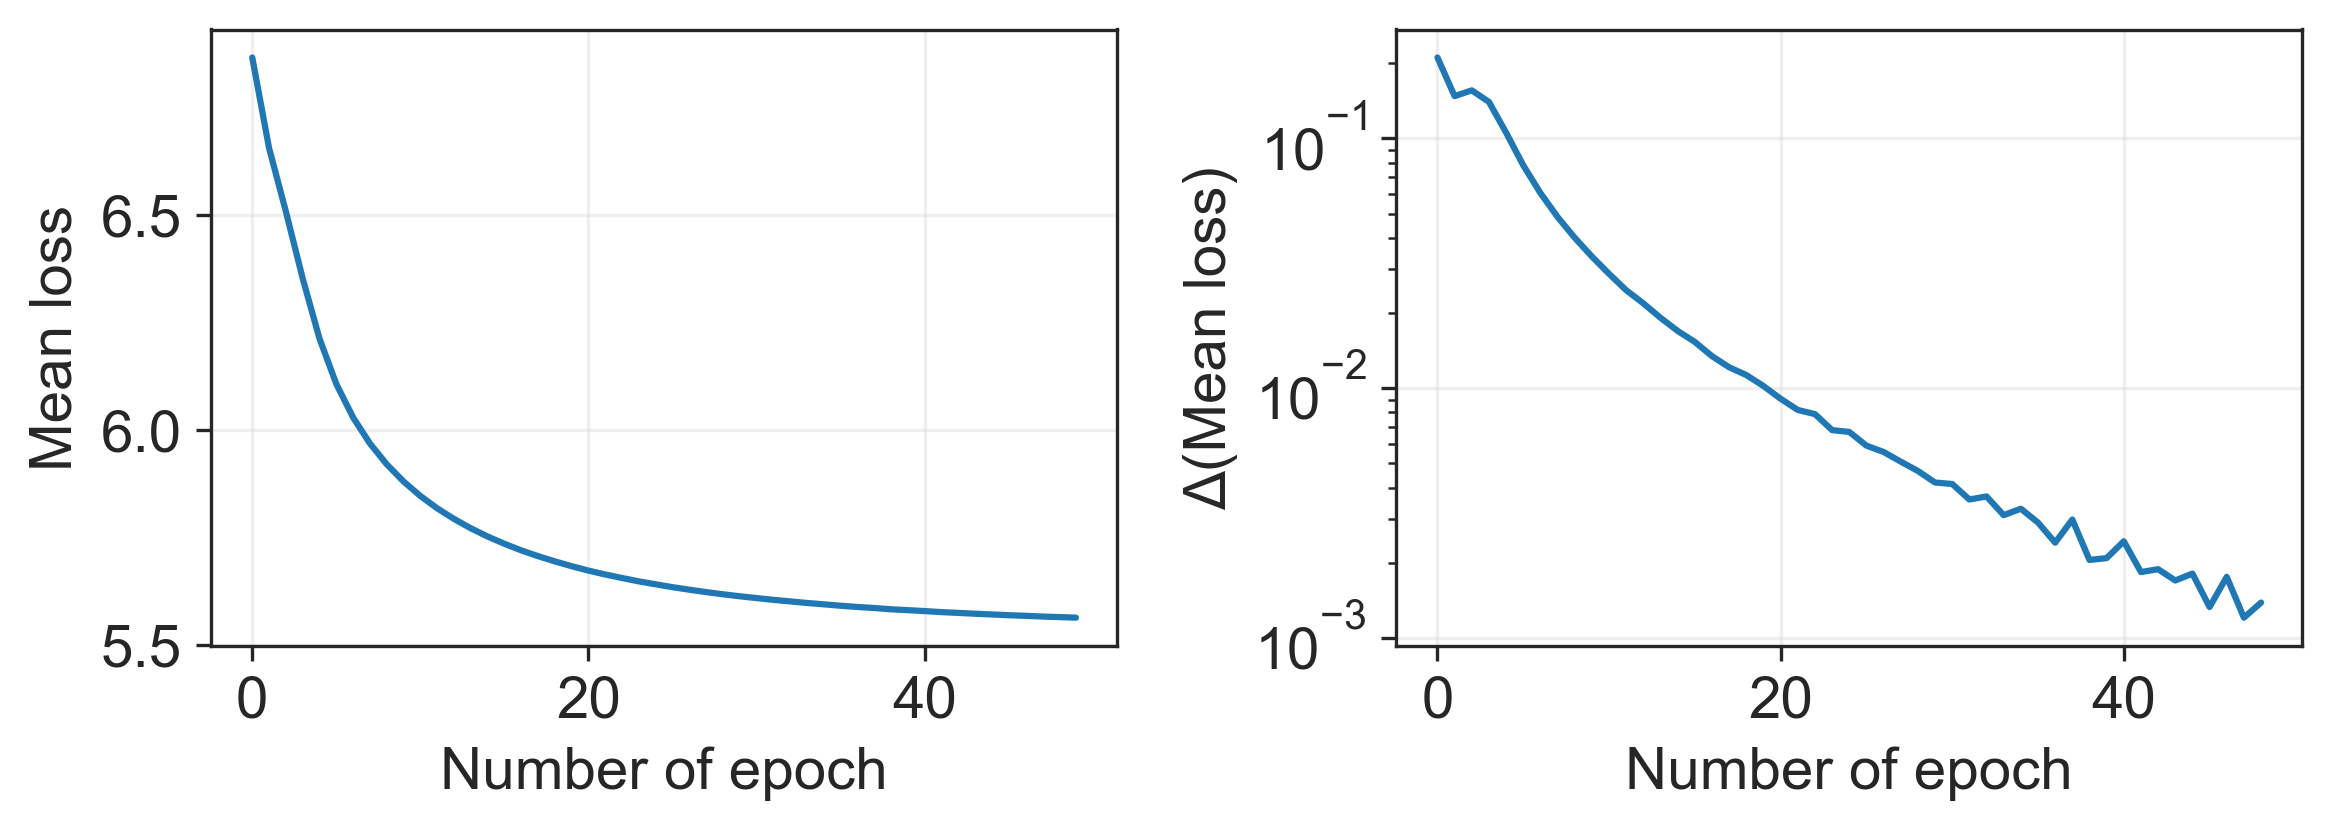

In [25]:
sl.pl.epochs_loss(clones_pert)

In [26]:
sc.pp.neighbors(clones_pert, use_rep="word2vec")
sc.tl.umap(clones_pert, min_dist=0.3)
clones_pert.obs["injection_time"] = [i.split(":")[0] for i in clones_pert.obs_names]

2024-05-06 02:42:40.565964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-06 02:42:40.595985: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 02:42:41.609240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-06 02:42:41.609349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-06 02:42:41.609359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

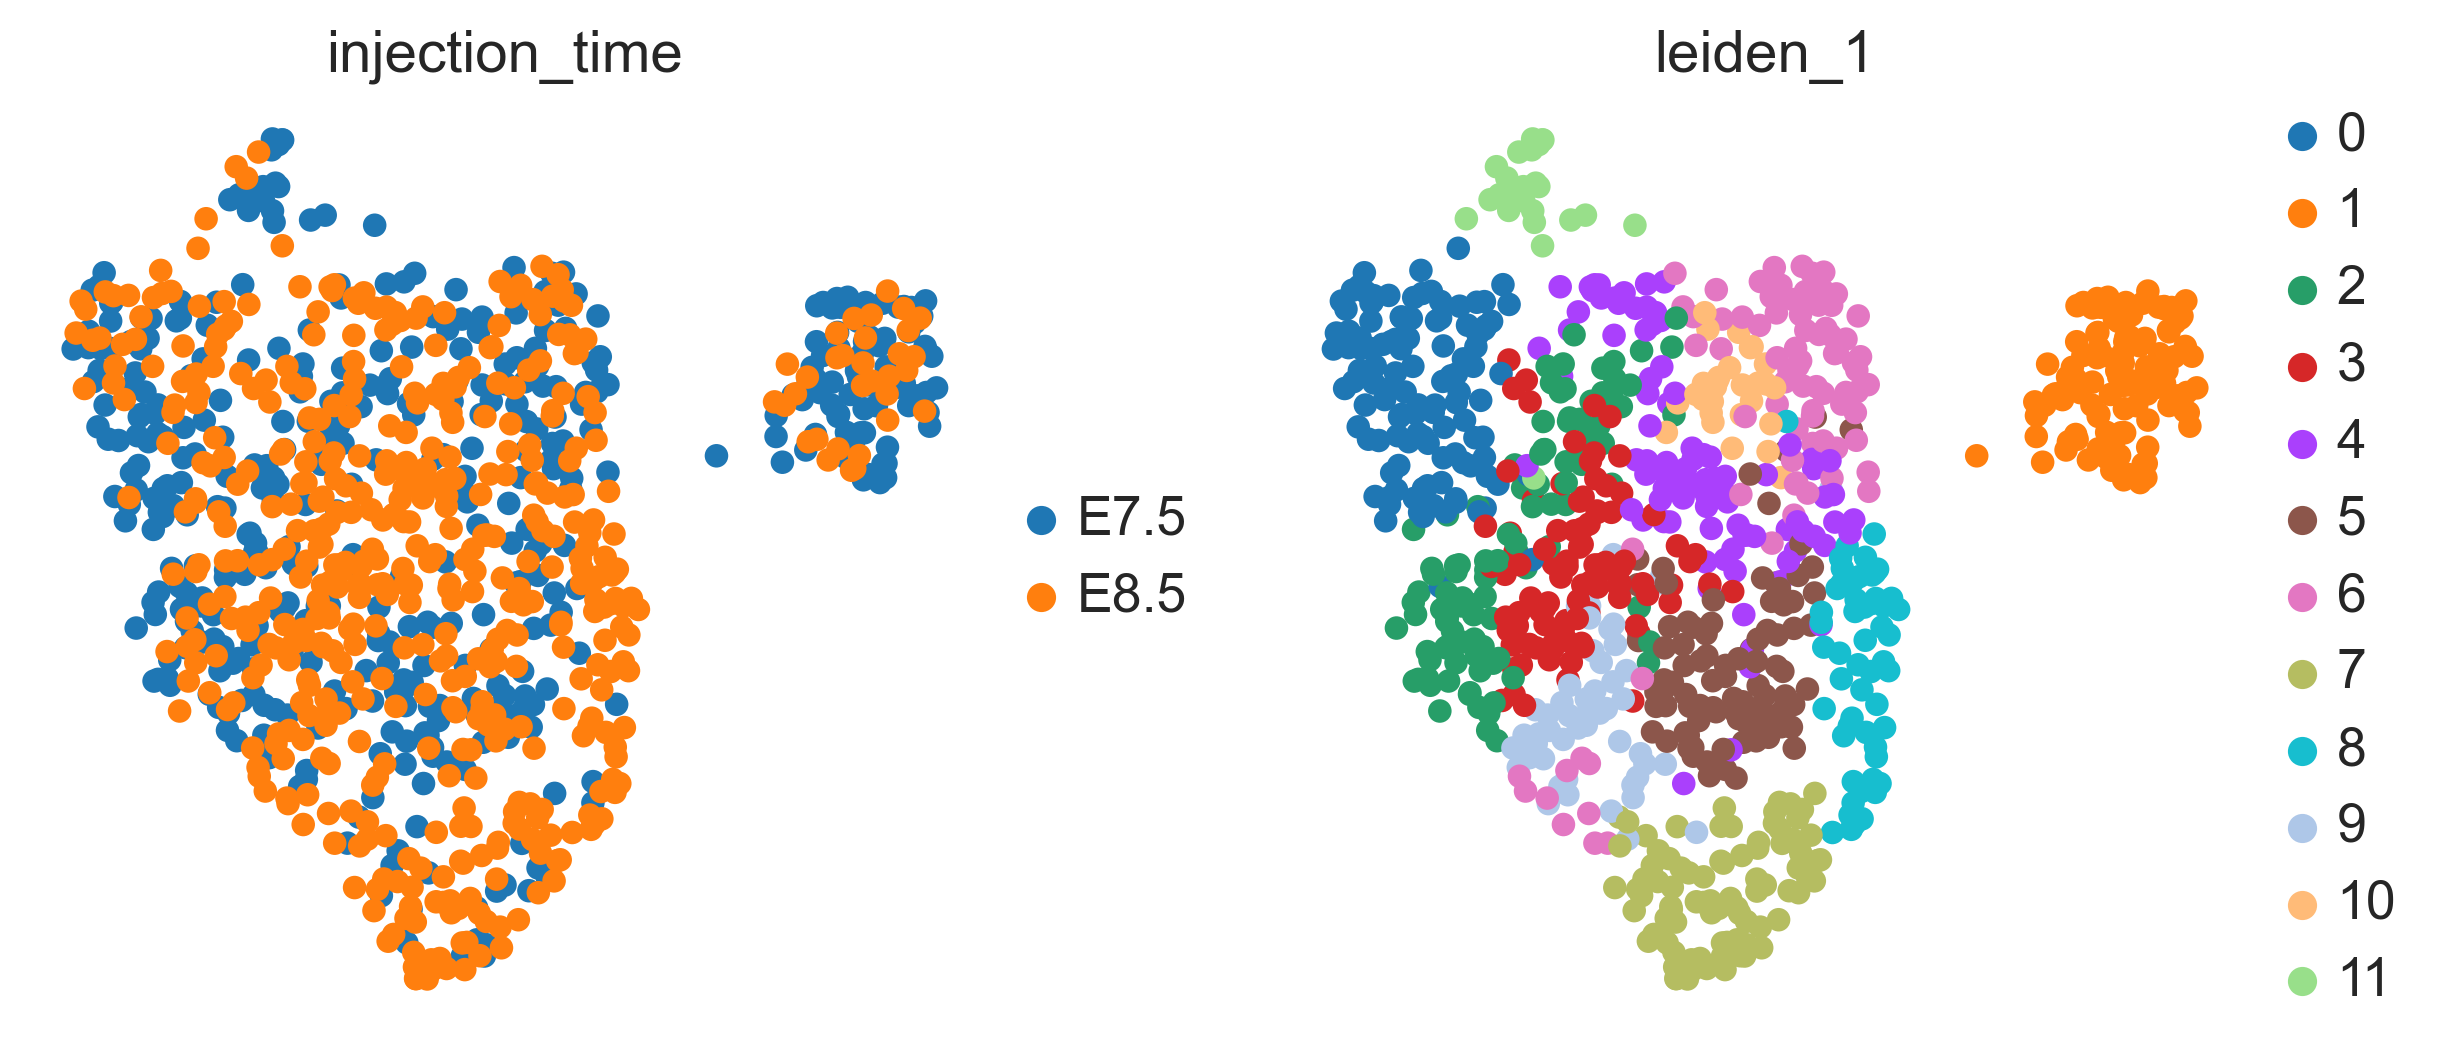

In [27]:
for resolution in [0.5, 1, 1.5, 2]:
    sc.tl.leiden(
        clones_pert,
        resolution=resolution,
        key_added=f"leiden_{resolution}",
    )
sc.pl.umap(clones_pert, color=["injection_time", "leiden_1"], frameon=False)

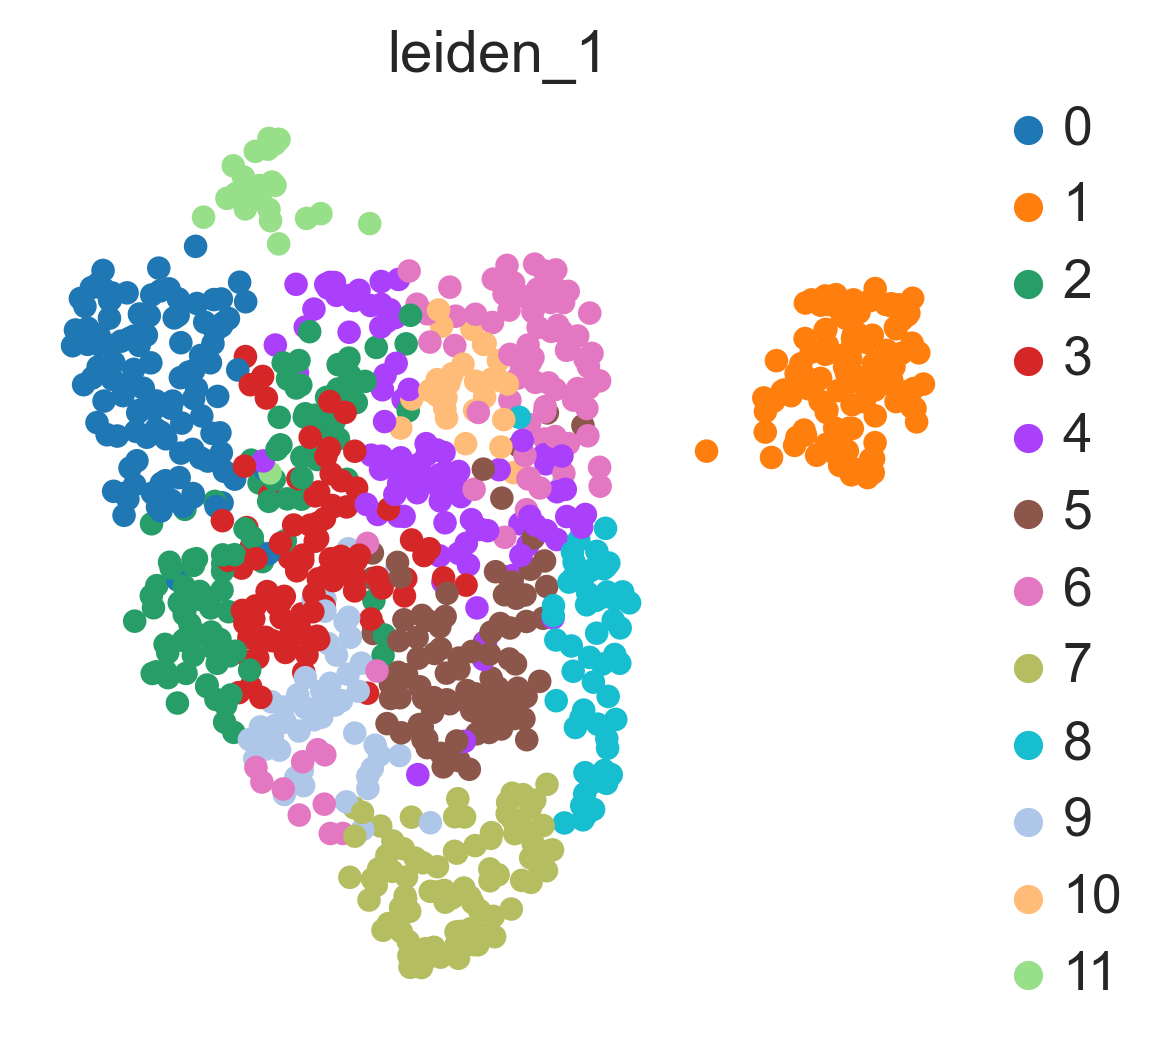

In [178]:
sc.pl.umap(clones_pert, color=["leiden_1"], frameon=False, save="clonal_clusters_NC.pdf")

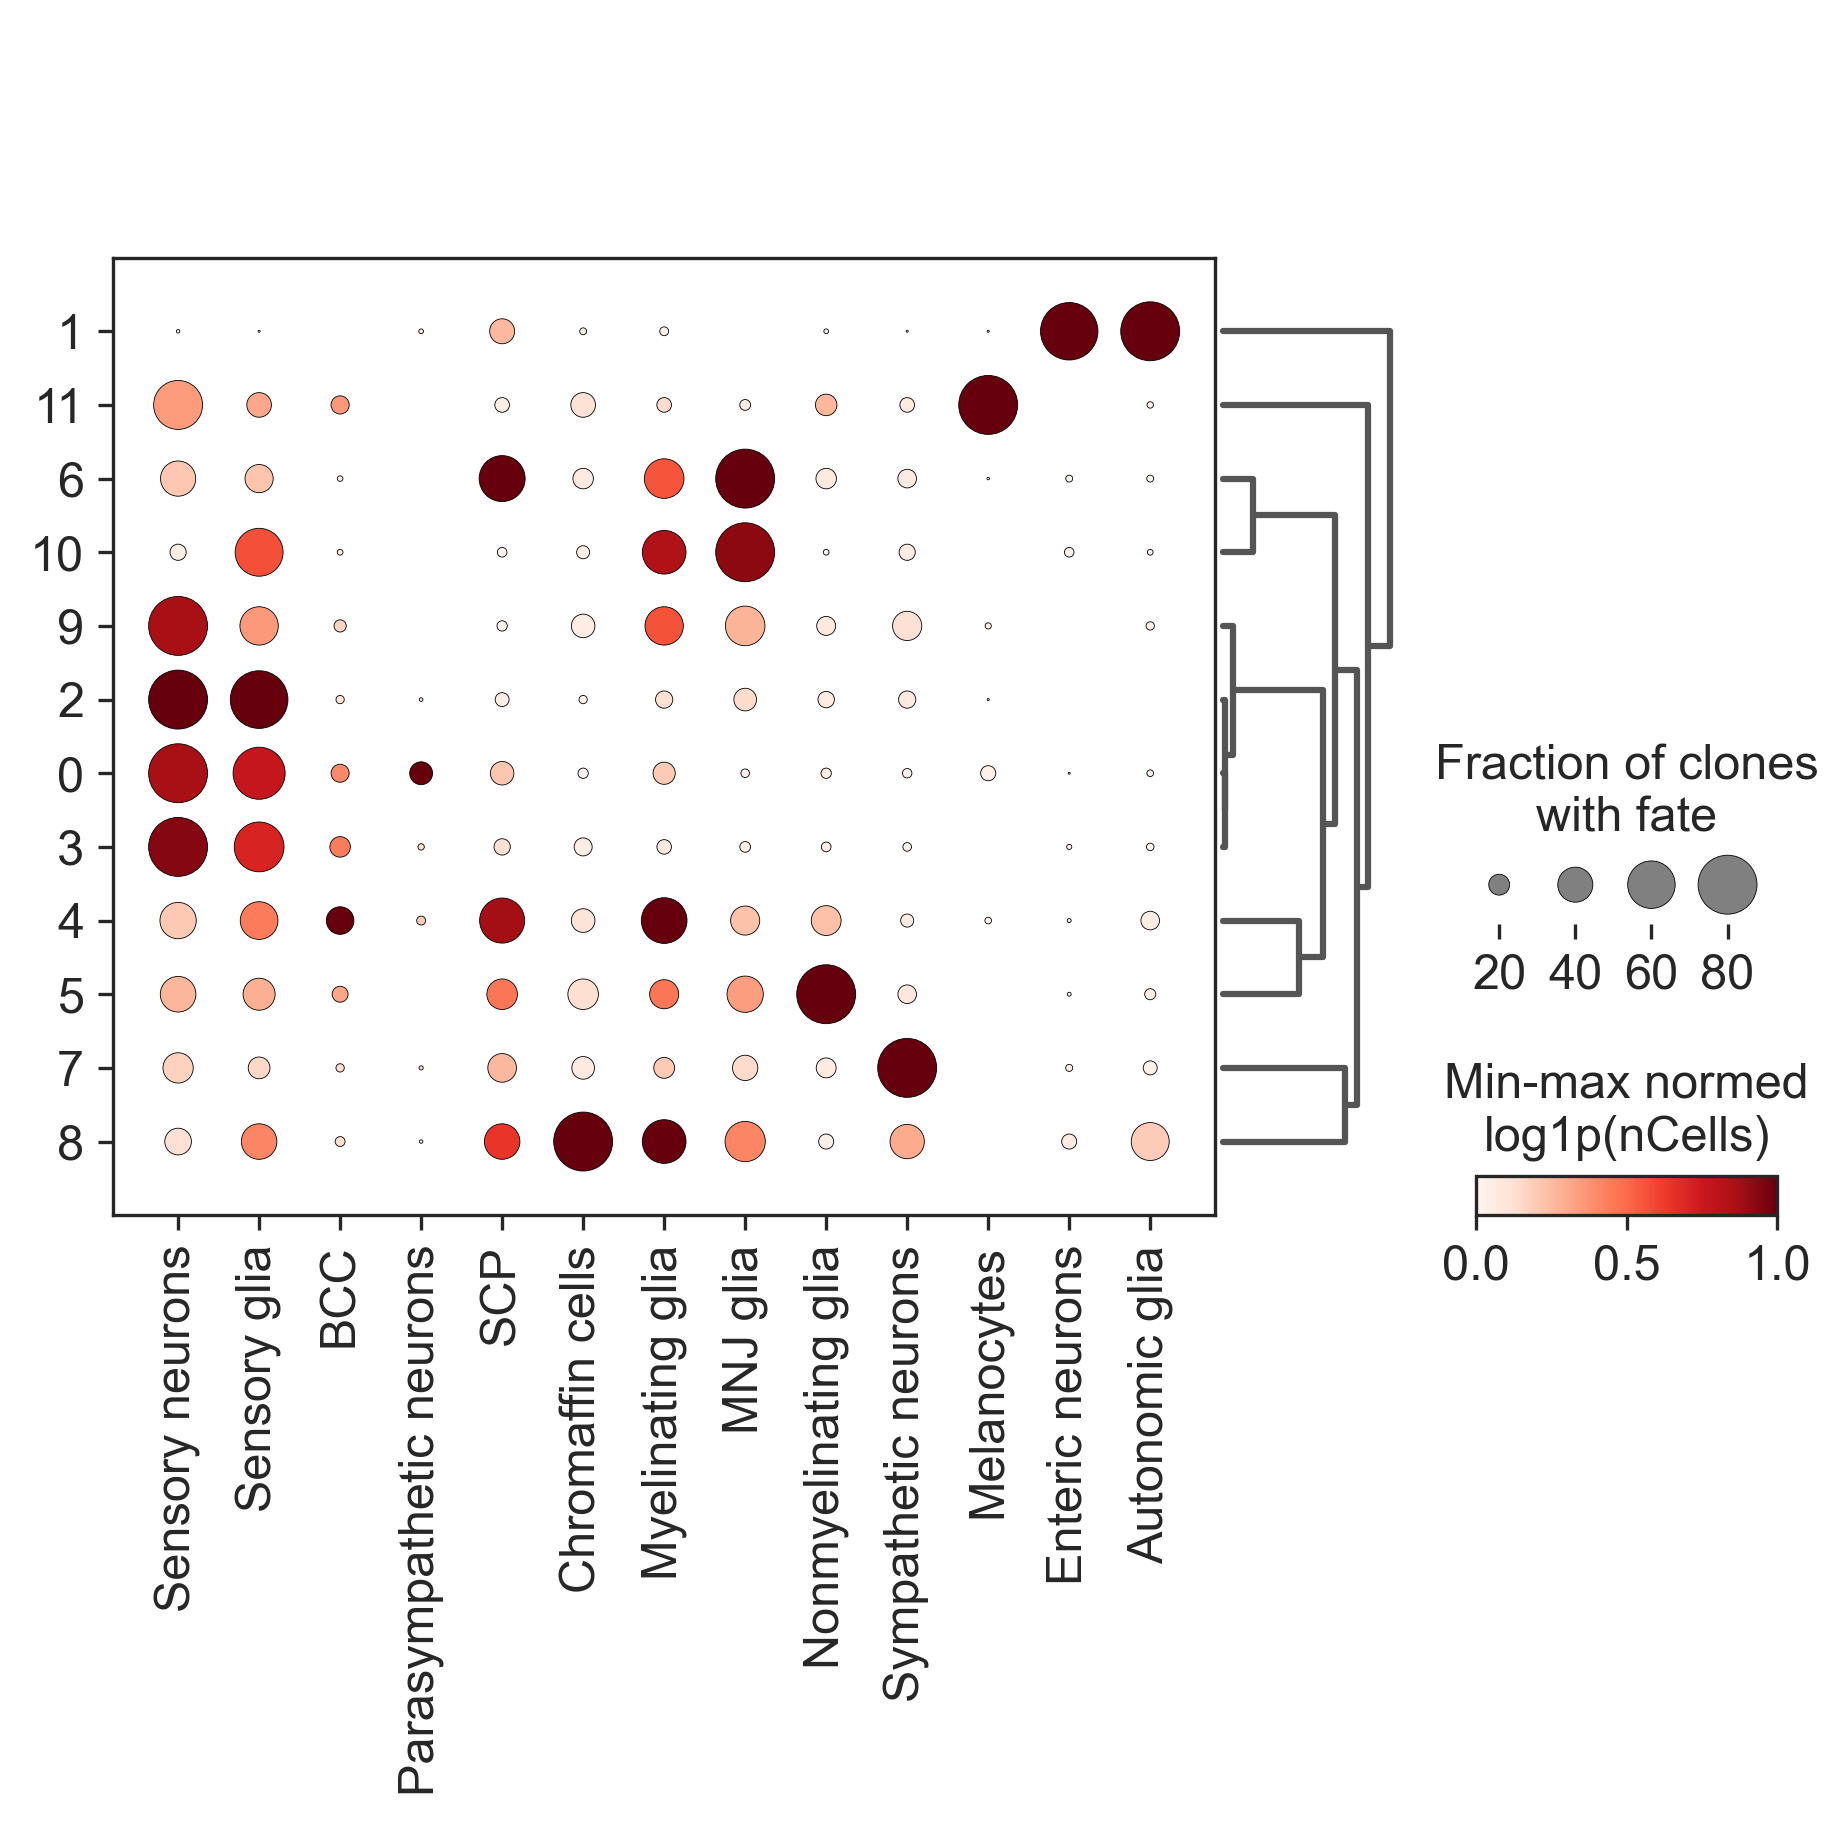

In [179]:
from scipy.cluster.hierarchy import linkage, dendrogram

clones_pert.X = pd.DataFrame(clones_pert.X).fillna(0).values
ct_order = clones_pert.var_names[
    dendrogram(linkage(clones_pert.X.T, method="average", metric="correlation"), no_plot=True)["leaves"][::-1]
]

sc.tl.dendrogram(clones_pert, use_rep="X", groupby="leiden_1", cor_method="pearson", linkage_method="average")
sc.pl.dotplot(
    clones_pert,
    var_names=ct_order,
    groupby="leiden_1",
    log=False,
    standard_scale="var",
    dot_max=0.8,
    dendrogram=True,
    colorbar_title="Min-max normed\nlog1p(nCells)",
    size_title="Fraction of clones\nwith fate",
    save="clonal_clusters.pdf"
)

In [50]:
clone_to_pert = dict(adata_fake.obs[["clones", "CRISPR:predicted"]].values)
clones_pert.obs["perturbation"] = ["EtOH" if "injection19" in obs else clone_to_pert[obs] for obs in clones_pert.obs_names]
clones_pert.obs["perturbation"] = ["multiple" if "|" in str(i) else i for i in clones_pert.obs["perturbation"]]
clones_pert.obs["perturbation"] = clones_pert.obs["perturbation"].fillna("NA")

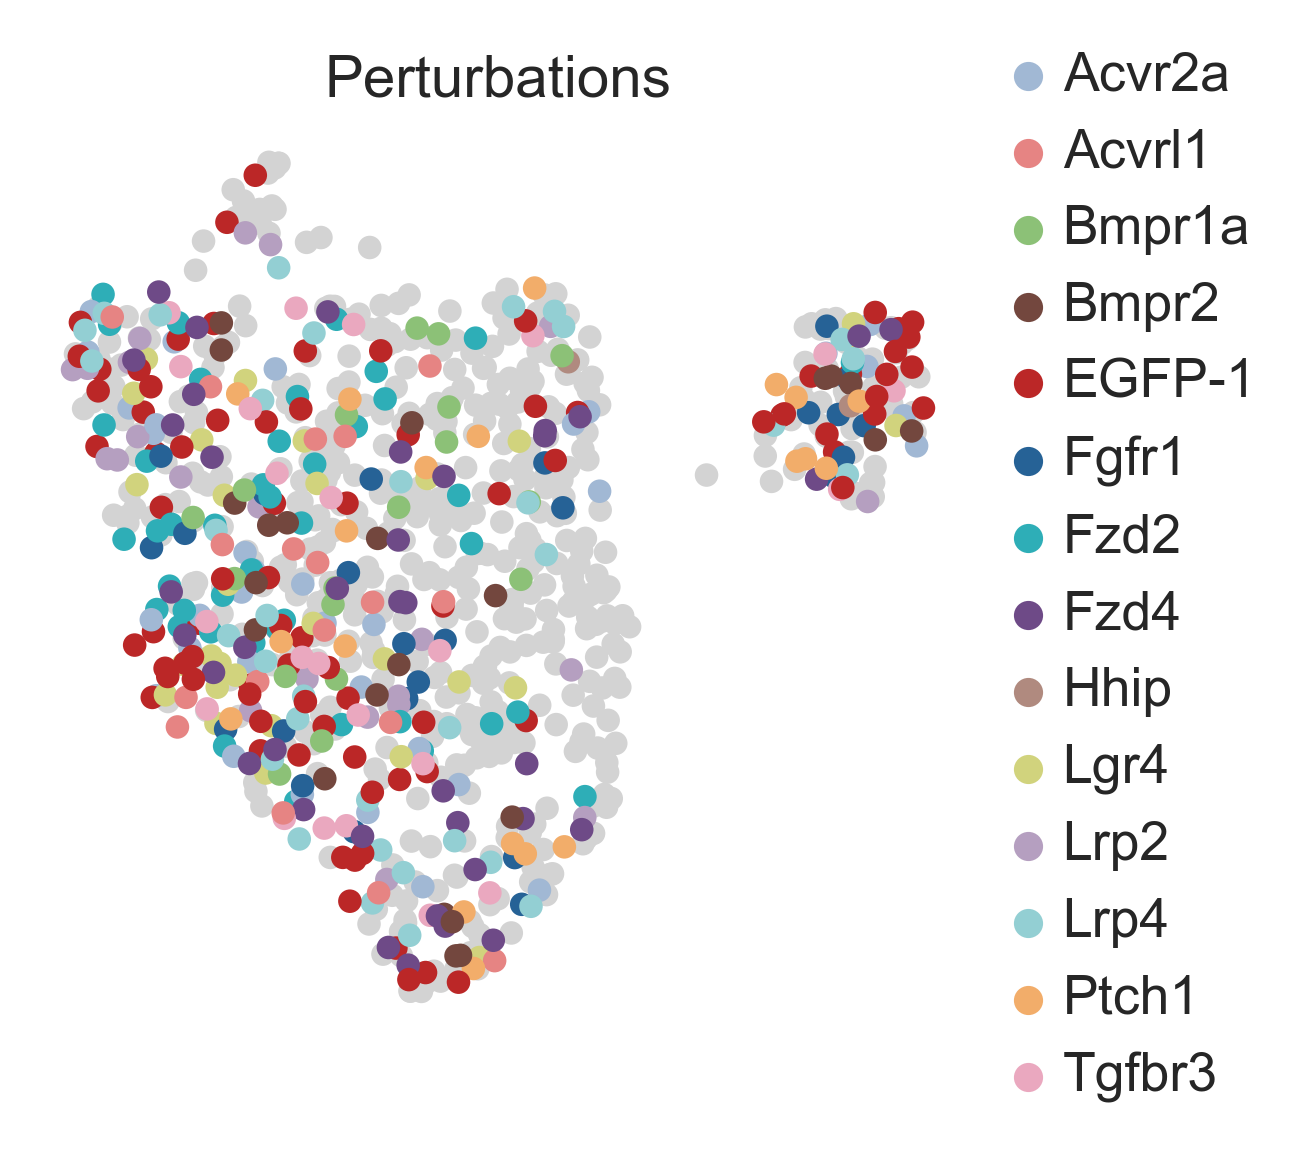

In [51]:
perturbation_colors = {
    "Acvr2a": "#a1b8d4",
    "Acvrl1": "#e68483",
    "Bmpr1a": "#8cc177",
    "Bmpr2": "#73473e",
    "EGFP-1": "#bb2727",
    "Fgfr1": "#266296",
    "Fzd2": "#2eaeb7",
    "Fzd4": "#6e4a87",
    "Hhip": "#b08a7f",
    "Lgr4": "#d1d37d",
    "Lrp2": "#b59fc0",
    "Lrp4": "#93cfd3",
    "Ptch1": "#f2ad6a",
    "Tgfbr3": "#eaa8bf",
    "multi_gRNA": "#e26b26",
    "uncertain": "#a4ad55",
    "NA": "#cccccc",
    "multiple": "#cccccc",
}

clones_pert.obs["perturbation"] = clones_pert.obs["perturbation"].astype("category")
clones_pert.uns["perturbation_colors"] = [perturbation_colors[pert] for pert in clones_pert.obs.perturbation.cat.categories]

to_draw = [i for i in set(clones_pert.obs["perturbation"]) if i not in ["NA", "multiple", "uncertain"]]
sc.pl.umap(clones_pert, color="perturbation", groups=to_draw, na_in_legend=False, title="Perturbations", frameon=False, save="nc_pert_umap.pdf")

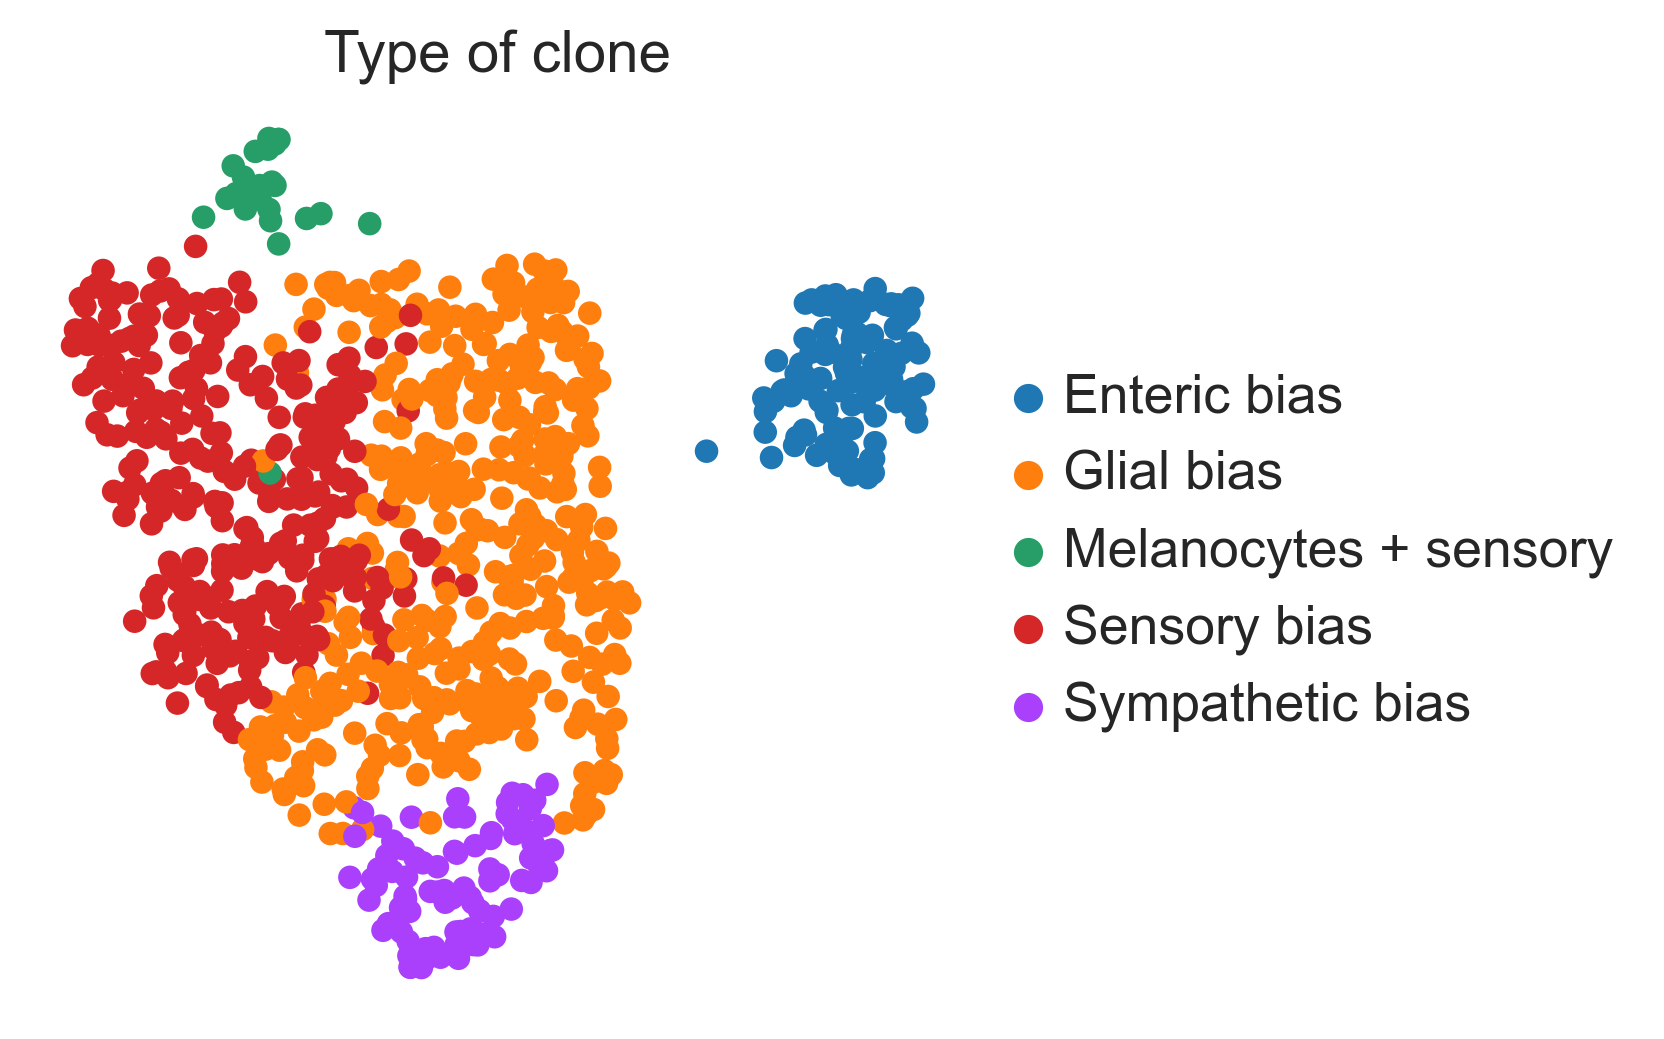

In [157]:
ct_to_leiden = {
    "Sensory bias": ["0", "2", "3"],
    "Glial bias": ["4", "5", "6", "8", "9", "10"],
    "Enteric bias": ["1"],
    "Sympathetic bias": ["7"],
    "Melanocytes + sensory": ["11"],
}

leiden_to_ct = {}
for ct in ct_to_leiden:
    for leiden in ct_to_leiden[ct]:
        leiden_to_ct[leiden] = ct

clones_pert.obs["clone_type"] = [leiden_to_ct[cluster] for cluster in clones_pert.obs["leiden_1"]]
sc.pl.umap(clones_pert, color=["clone_type"], frameon=False, title=["Type of clone"], save="nc_clone_type.pdf")

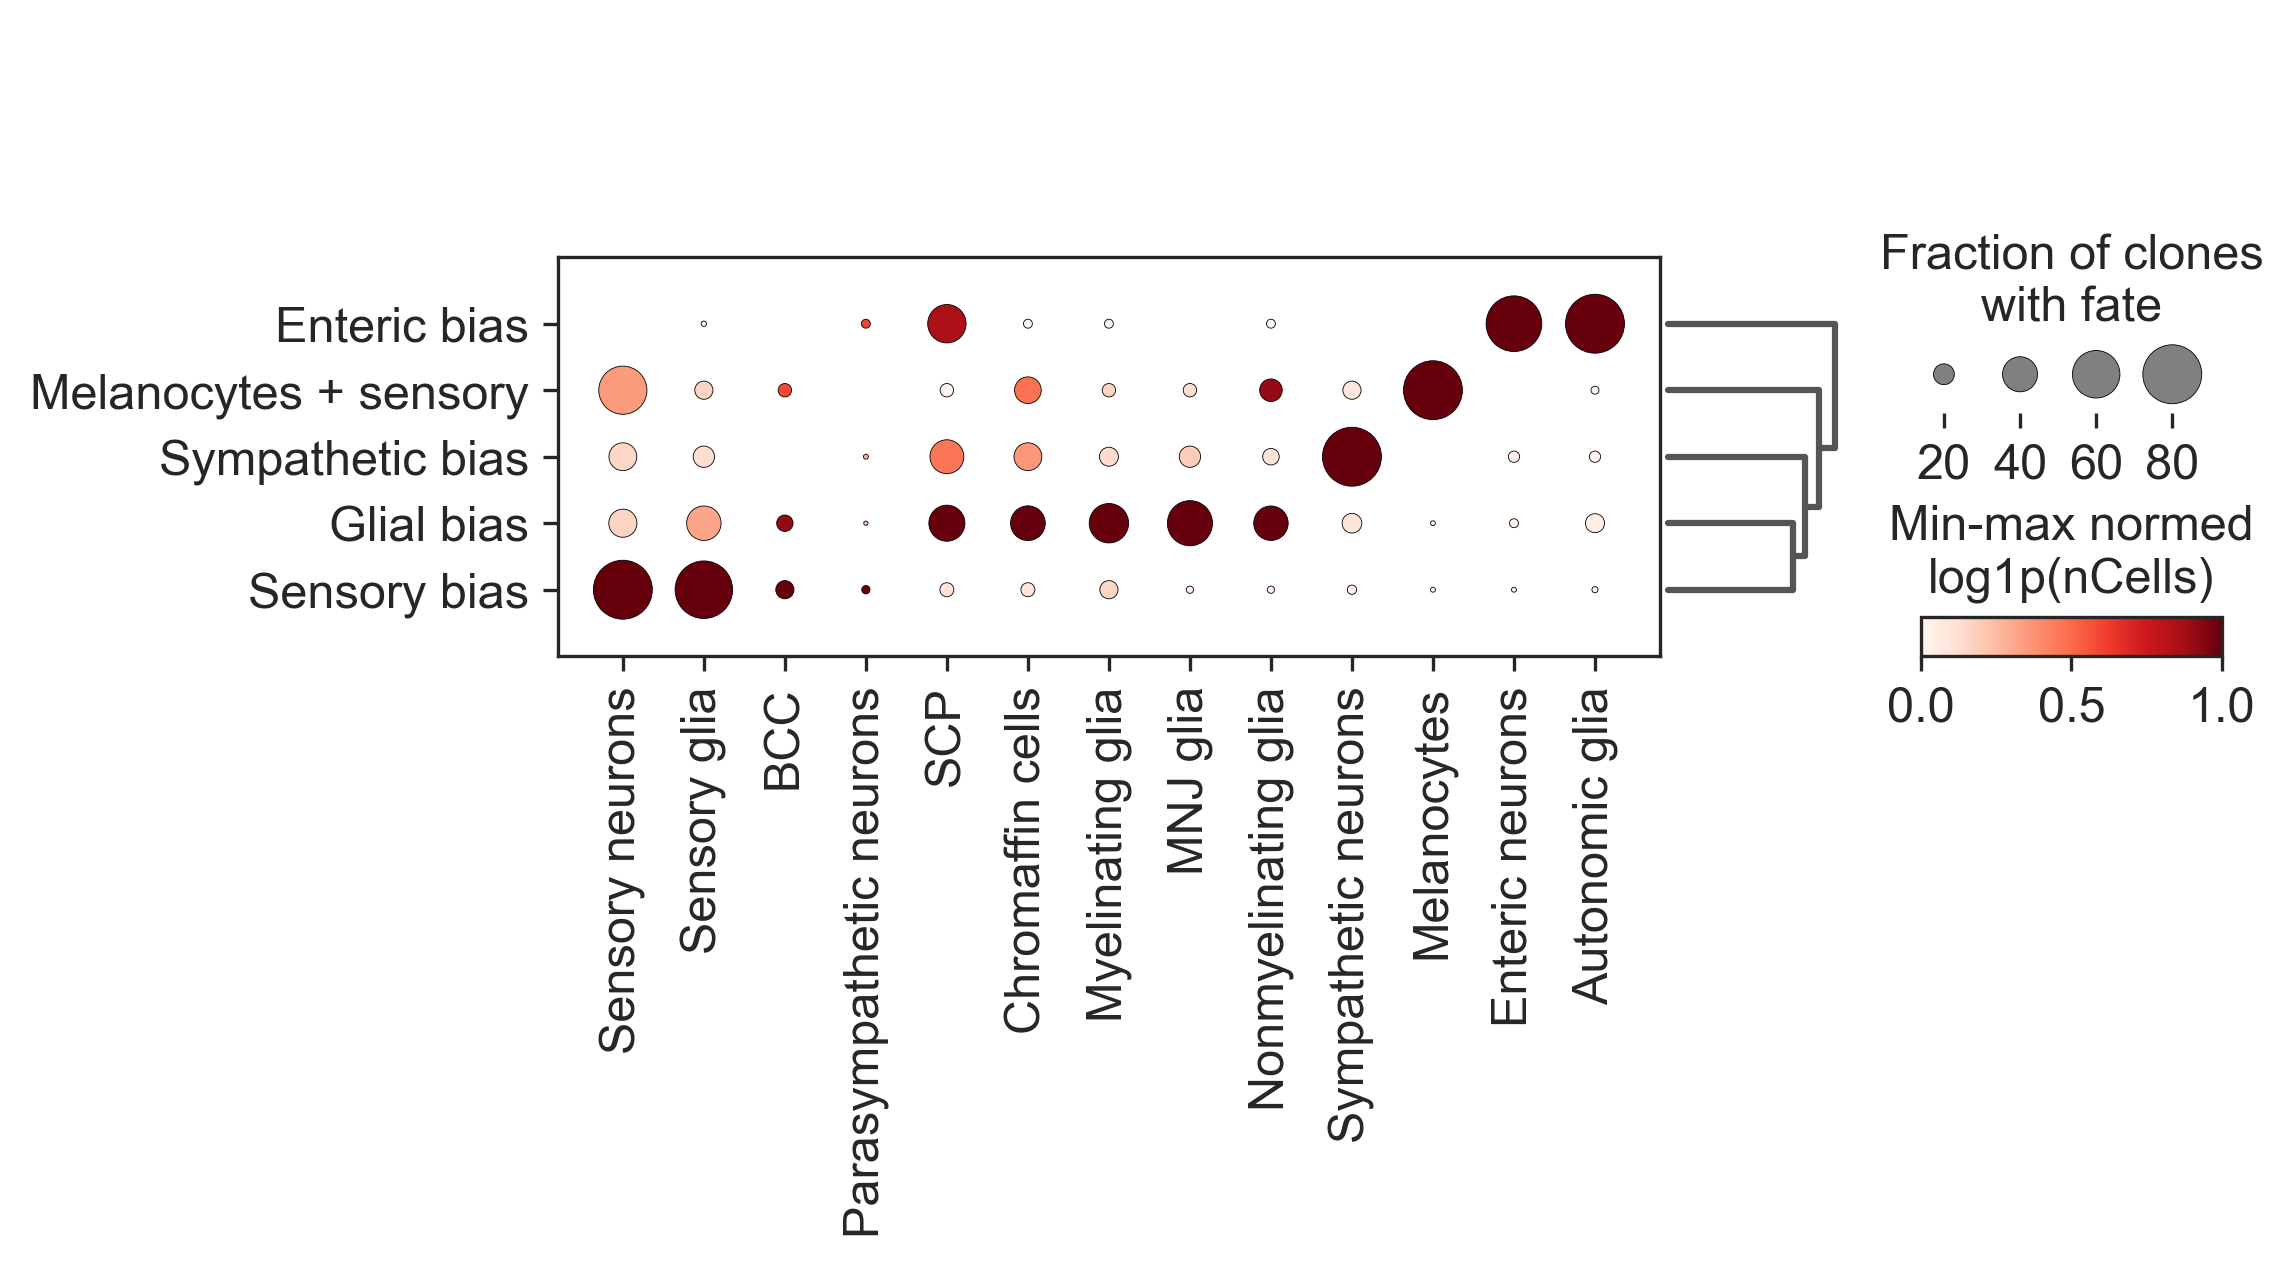

In [158]:
clones_pert.obs["injection"] = pd.Series(clones_pert.obs_names).apply(lambda x: x.split(":")[1]).values
clones_control = clones_pert[~clones_pert.obs["injection"].isin(["injection8", "injection9", "injection10", "injection18"])]

sc.tl.dendrogram(clones_control, use_rep="X", groupby="clone_type", cor_method="pearson", linkage_method="average")
sc.pl.dotplot(
    clones_control,
    var_names=ct_order,
    groupby="clone_type",
    log=False,
    standard_scale="var",
    dot_max=0.8,
    dendrogram=True,
    colorbar_title="Min-max normed\nlog1p(nCells)",
    size_title="Fraction of clones\nwith fate",
    save="clonal_distribution_dotplot.pdf",
)

In [73]:
clones_pert.obs["clone_size"] = clones_pert.X.sum(axis=1)

In [74]:
def compare_pcts(group1_pcts, group2_pcts):
    """
    BetaReg wrapper for comparison of percentage data.
    
    Parameters
    ----------
    group1_pcts : list
        List with fractions within group 1.
    group2_pcts : list
        List with fractions within group 2.
        
    Returns
    ----------
    p-value of regression coefficient.
    """
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri, Formula
    from rpy2.robjects.packages import importr
    import pandas as pd

    pandas2ri.activate()
    betareg = importr("betareg")
    base = importr("base")
    
    df = robjects.conversion.py2rpy(pd.DataFrame({
        "group" : ["A"] * len(group1_pcts) + ["B"] * len(group2_pcts),
        "pcts" : group1_pcts + group2_pcts
    }))
    regression = betareg.betareg(Formula("pcts ~ group"), data = df)

    return base.summary(regression)[0][0].flatten()[7]

def pval_to_star(pval, GSEA_threshold=False):
    """
    This function returns star-formatted p-value.
    
    Parameters
    ----------
    pval : float
        P-value
        
    Returns
    ----------
    Star-formatted p-value.
    """
    if pval < 0.0001:
        return "****"
    elif pval < 0.001:
        return "***"
    elif pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    elif pval < 0.25 and GSEA_threshold:
        return "."
    else:
        return " "

In [75]:
repet = {}
repet_size = {}

for injection in ["injection8", "injection9", "injection10"]:
    clones_subset = clones_pert[pd.Series(clones_pert.obs_names).apply(lambda x: injection in x)]
    
    df = clones_subset.obs.groupby(["perturbation", "clone_type"]).size().unstack()
    df = (df.T / df.sum(axis=1)).T
    df = df[~df.index.isin(["multiple", "NA", "uncertain"])]
    
    repet[injection] = df
    
    df = clones_subset.obs.groupby(["perturbation", "clone_type"]).median()["clone_size"].unstack()
    df = df[~df.index.isin(["multiple", "NA", "uncertain"])]
    
    repet_size[injection] = df

In [76]:
from statsmodels.stats.multitest import multipletests

result_fc = {}
result_p = {}

pseudocount = 0.1

for ct in ["Glial bias", "Sensory bias", "Enteric bias", "Sympathetic bias"]:
    result_fc[ct] = {}
    result_p[ct] = {}
    
    control_pcts = [
        repet["injection8"][ct]["EGFP-1"] + pseudocount, 
        repet["injection9"][ct]["EGFP-1"] + pseudocount, 
        repet["injection10"][ct]["EGFP-1"] + pseudocount, 
    ]
    for genotype in ["Acvr2a", "Fgfr1", "Fzd2", "Lgr4", "Lrp2"]:
        genotype_pcts = [
            repet["injection8"][ct][genotype] + pseudocount, 
            repet["injection9"][ct][genotype] + pseudocount, 
            repet["injection10"][ct][genotype] + pseudocount, 
        ]
        result_fc[ct][genotype] = np.mean(genotype_pcts) / np.mean(control_pcts)
        result_p[ct][genotype] = compare_pcts(genotype_pcts, control_pcts)
        
result_fc = pd.DataFrame(result_fc).T
result_p = pd.DataFrame(result_p).T
result_fdr = pd.DataFrame(
    multipletests(result_p.values.flatten(), method="fdr_bh")[1].reshape(4, 5),
    index=result_p.index,
    columns=result_p.columns,
)

for genotype in result_fdr.columns:
    result_fdr[genotype] = result_fdr[genotype].apply(pval_to_star)

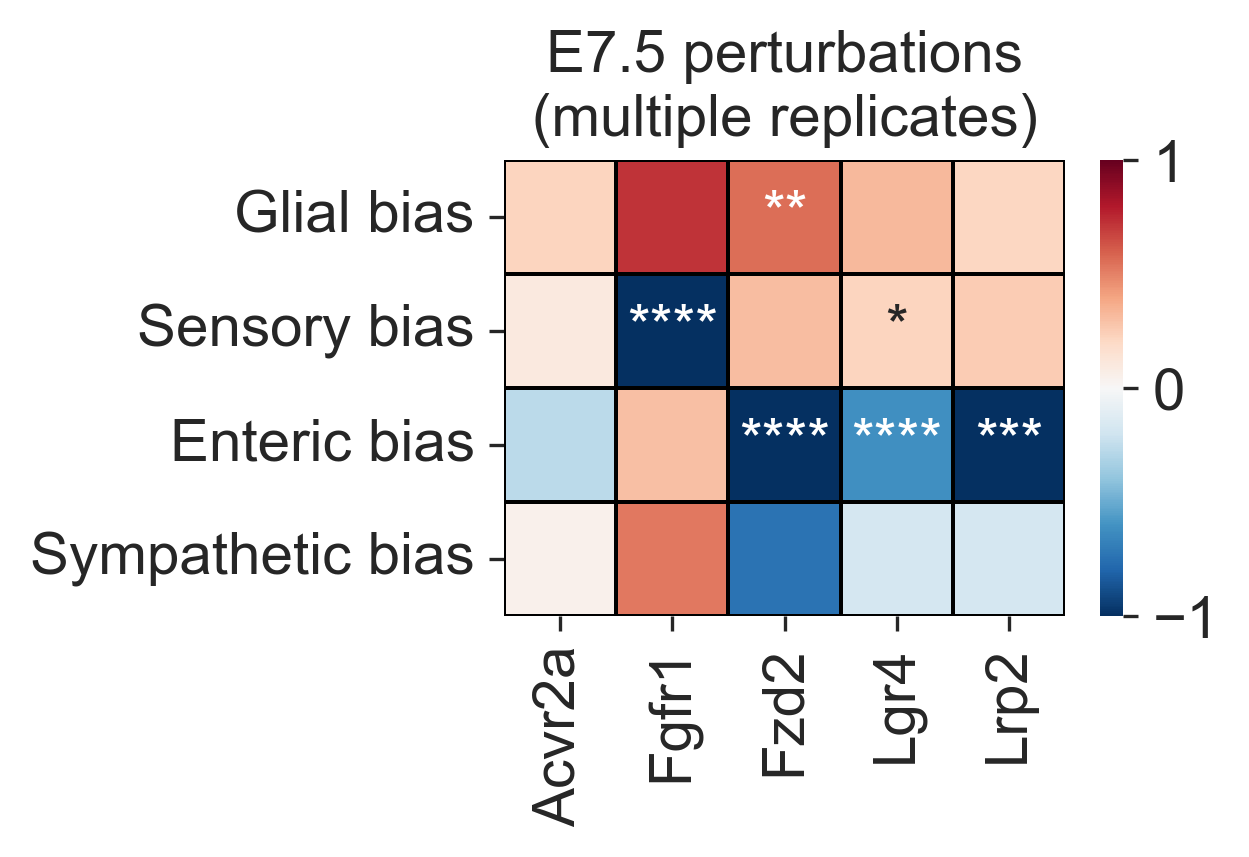

In [159]:
fig, ax = plt.subplots(figsize=(3, 2))

sns.heatmap(
    data=np.log2(result_fc),
    ax=ax,
    linecolor="black",
    linewidth=0.5,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    annot=result_fdr,
    fmt="",
)

ax.set_ylabel("")
ax.set_xlabel("")

ax.set_title("E7.5 perturbations\n(multiple replicates)")

plt.savefig("figures/pert_stats.pdf", bbox_inches="tight")

In [78]:
adata_NC.write_h5ad("../02_Fate_distribution/NC_work_in_progress/adata_control.h5ad")
adata_NC_pert.write_h5ad("../02_Fate_distribution/NC_work_in_progress/adata_pert.h5ad")
clones_pert.write_h5ad("../02_Fate_distribution/NC_work_in_progress/clones_pert.h5ad")

In [89]:
adata.obs["dummy"] = "other"
adata.obs["dummy"][
    (adata.obs.batch.isin(["injection8", "injection9", "injection10"]).values) &
    (adata.obs["CRISPR:predicted"] == "EGFP-1")
] = "control"

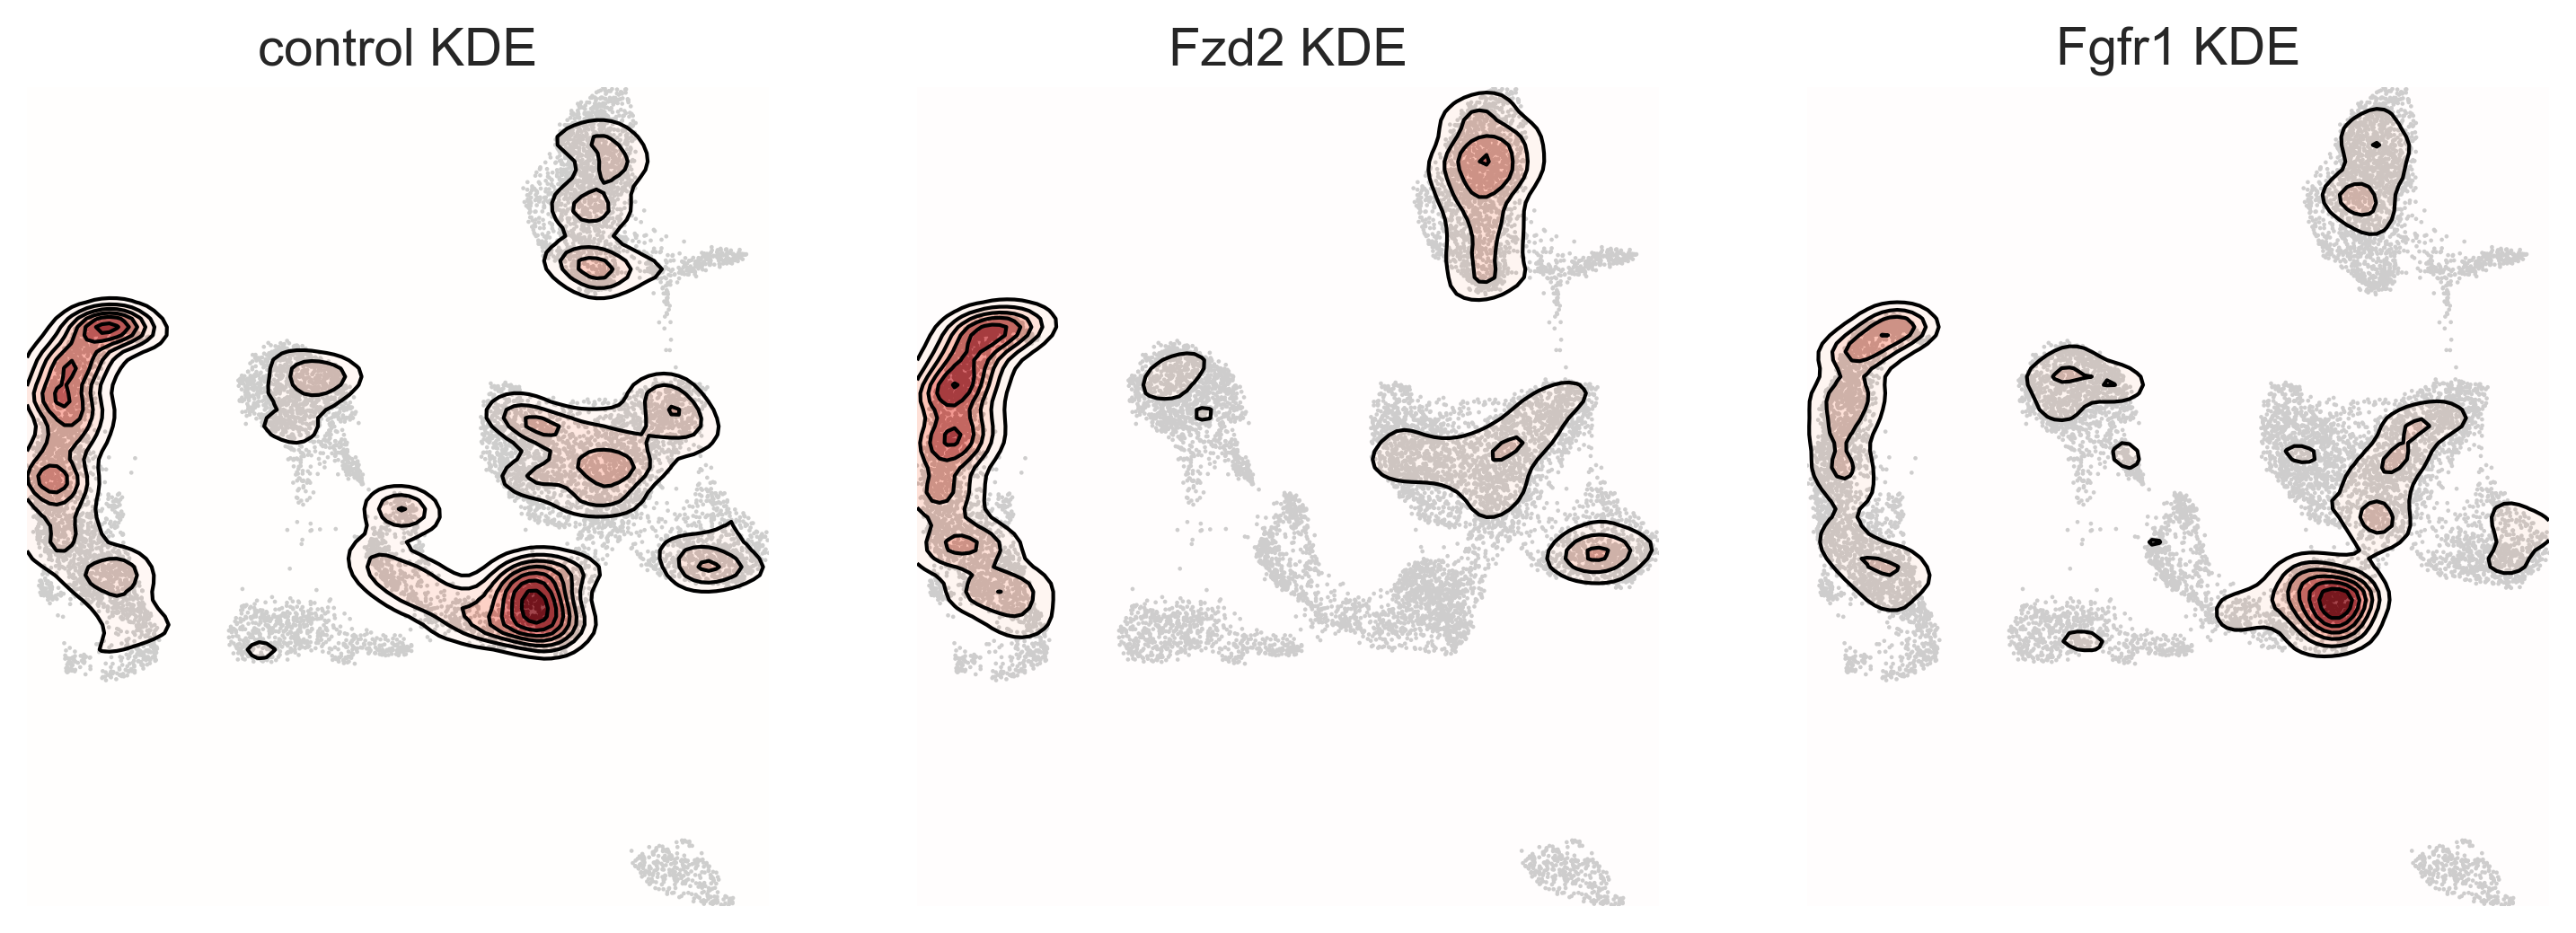

In [160]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sl.pl.kde(adata, groupby="CRISPR:predicted", group="Fzd2", ax=axes[1])
sl.pl.kde(adata, groupby="dummy", group="control", ax=axes[0])
sl.pl.kde(adata, groupby="CRISPR:predicted", group="Fgfr1", ax=axes[2])

plt.savefig("figures/some_kdes.pdf", bbox_inches="tight")

In [96]:
full_adata = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_merged.h5ad")

In [99]:
from tqdm import tqdm

Mes_counts = []
CNS_counts = []

for clone in tqdm(clones_pert.obs_names):
    timepoint = clone[:4]
    clone = clone[5:]
    
    clone_cells = full_adata.obs[full_adata.obs[f"{timepoint}:clones"] == clone]
    clone_cells = clone_cells[~clone_cells.index.isin(adata.obs_names)]
    CNS_counts.append(sum((clone_cells.celltype_l0 == "Neurons") & ~(clone_cells.celltype_l2.isin(["Autonomic HOXB", "Sensory"]))))
    Mes_counts.append(sum(clone_cells.celltype_l0 == "Mesenchyme"))

100%|██████████| 940/940 [00:02<00:00, 365.28it/s]


In [100]:
clones_pert.obs["Mes_total"] = Mes_counts
clones_pert.obs["CNS_total"] = CNS_counts

clones_pert.obs["Mes_total_log1p"] = np.log1p(Mes_counts)
clones_pert.obs["CNS_total_log1p"] = np.log1p(CNS_counts)

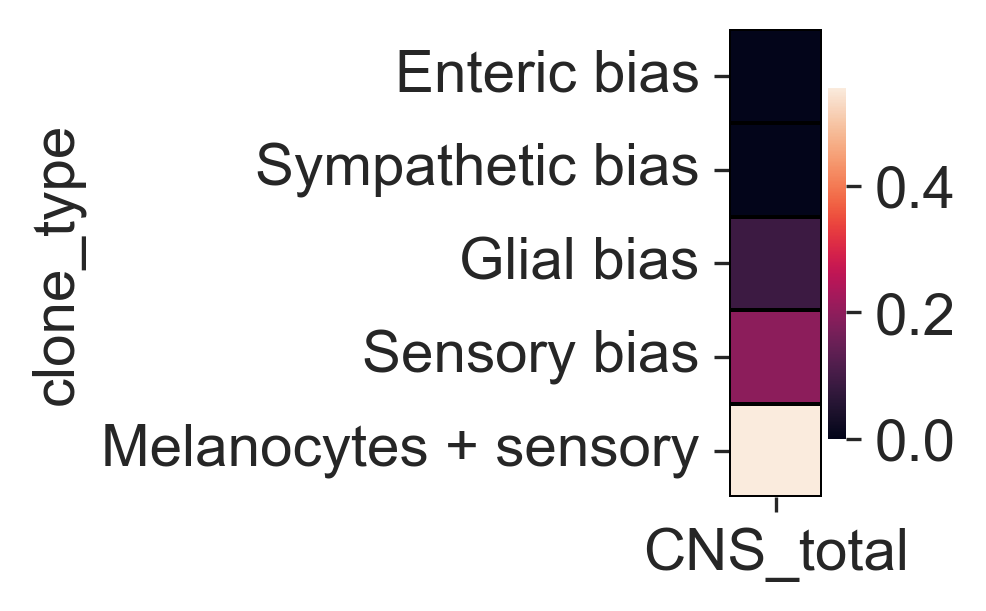

In [109]:
fig, ax = plt.subplots(figsize=(0.5, 2.5))

clones_control = clones_pert[clones_control.obs_names]
df = pd.DataFrame((
    (clones_control.obs.CNS_total.astype(int) > 0).astype(int).groupby(clones_control.obs.clone_type).sum() /
    clones_control.obs.CNS_total.groupby(clones_control.obs.clone_type).size()
).sort_values())

sns.heatmap(data=df, linecolor="black", linewidth=0.5, square=True)

plt.savefig("figures/hetmap_pct_CNS.pdf", bbox_inches="tight")

In [113]:
expressions_pert = {}

for clone in clones_pert.obs_names:
    stage = clone[:4]
    clone_name = clone[5:]
    expressions_pert[clone] = adata[adata.obs[f"{stage}:clones"] == clone_name].X.mean(axis=0).A[0]
    
expressions_pert = pd.DataFrame(expressions_pert, index=adata.var_names).T

In [114]:
from scipy.sparse import csr_matrix

clones_pert_expr = sc.AnnData(
    X=csr_matrix(expressions_pert.values),
    obs=clones_pert.obs.copy(),
    var=pd.DataFrame(index=expressions_pert.columns),
    obsm=clones_pert.obsm,
    obsp=clones_pert.obsp,
)

In [116]:
genes = np.array([
    "Hoxc13", "Hoxc12", "Hoxc11",
    "Hoxd11", "Hoxc10", "Hoxd9",
    "Hoxc8", "Hoxa7", "Hoxc6", "Hoxb5",
    "Hoxb4"
])

anterio_posterior_signature = dict(enumerate(genes[::-1]))
anterio_posterior_signature = dict(zip(anterio_posterior_signature.values(), [i + 1 for i in anterio_posterior_signature.keys()]))

In [117]:
clones_pert_expr.obs["Hox_position"] = (
    clones_pert_expr[:, list(anterio_posterior_signature.keys())].X *
    np.array(list(anterio_posterior_signature.values())) / 
    clones_pert_expr[:, list(anterio_posterior_signature.keys())].X.sum(axis=1).T.A
)[0]

clones_pert_expr.obs["Hox_position"] = (
    clones_pert_expr.obs["Hox_position"] - clones_pert_expr.obs["Hox_position"].min()
) / (clones_pert_expr.obs["Hox_position"].max() - clones_pert_expr.obs["Hox_position"].min())

clones_pert_expr.obs["Hox_position"] = [i if str(i) != "nan" else 0.5 for i in clones_pert_expr.obs["Hox_position"]]

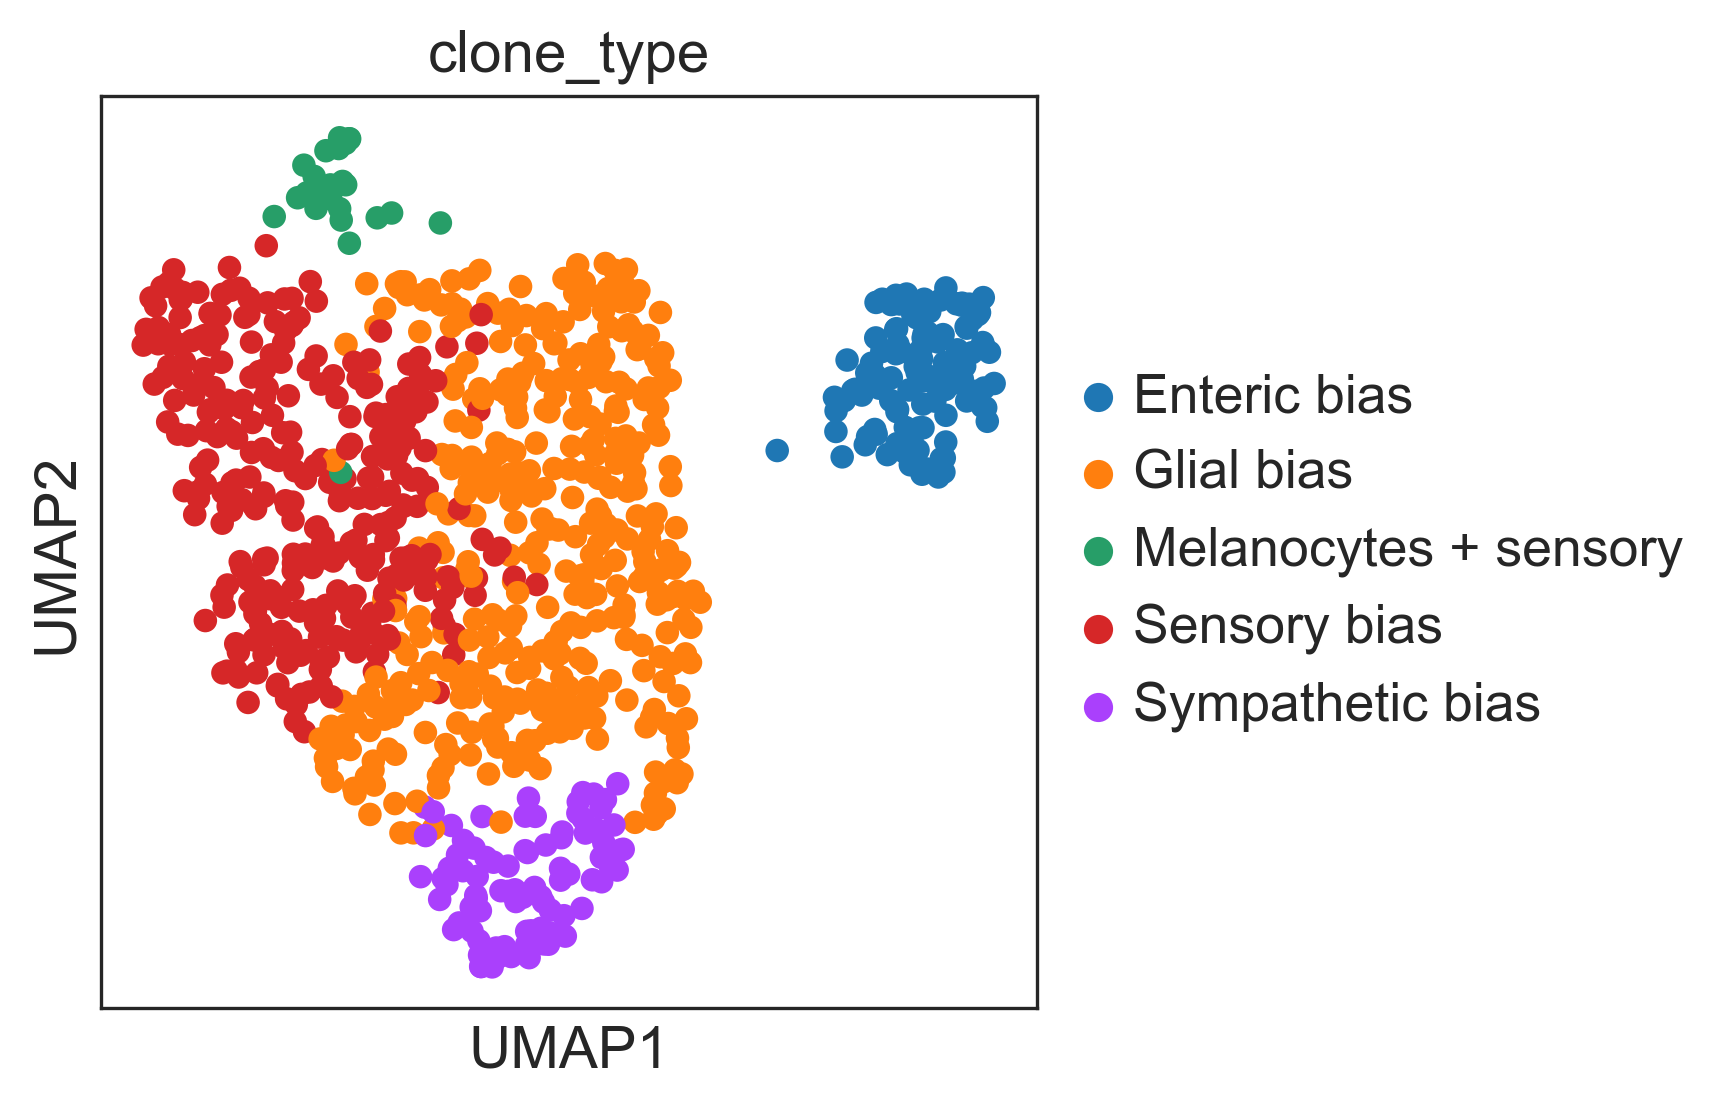

In [122]:
sc.pl.umap(clones_pert_expr, color="clone_type")

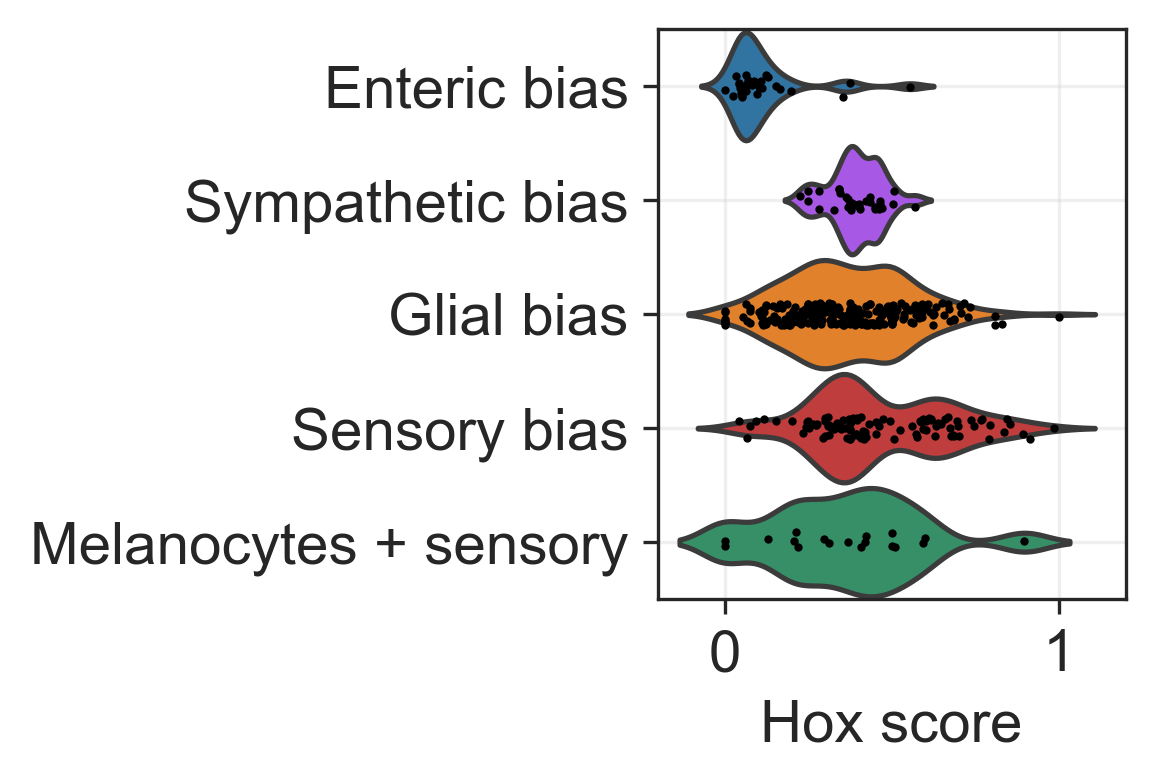

In [161]:
fig, ax = plt.subplots(figsize=(2, 2.5))

sns.violinplot(
    y="clone_type",
    x="Hox_position",
    data=clones_pert_expr[clones_control.obs_names].obs,
    width=0.95,
    inner=None,
    ax=ax,
    density_norm="width",
    bw_method=0.3,
    palette=dict(zip(
        clones_pert_expr.obs["clone_type"].cat.categories,
        clones_pert_expr.uns["clone_type_colors"],
    )),
    order=df.index,
)

sns.stripplot(
    y="clone_type",
    x="Hox_position",
    data=clones_pert_expr[clones_control.obs_names].obs,
    color="black",
    s=2,
    order=df.index,
)

ax.set_ylabel("")
ax.set_xlabel("Hox score")
ax.grid(alpha=0.3)
ax.set_xlim(-0.2, 1.2)

plt.savefig("figures/violin_HOX.pdf", bbox_inches="tight")

In [128]:
mapping = {"E7.5": {}, "E8.5": {}}

for clonename in clones_control.obs_names:
    timepoint = clonename.split(":")[0]
    clone = ":".join(clonename.split(":")[1:])
    mapping[timepoint][clone] = clones_control.obs.loc[clonename]["clone_type"]

In [130]:
clusters = []

for i, bc in adata.obs.iterrows():
    if (bc["E8.5:clones"] in mapping["E8.5"]) and (bc["E7.5:clones"] in mapping["E7.5"]):
        if mapping["E8.5"][bc["E8.5:clones"]] != mapping["E7.5"][bc["E7.5:clones"]]:
            clusters.append("conflict")
        else:
            clusters.append(mapping["E8.5"][bc["E8.5:clones"]])
    elif bc["E8.5:clones"] in mapping["E8.5"]:
        clusters.append(mapping["E8.5"][bc["E8.5:clones"]])
    elif bc["E7.5:clones"] in mapping["E7.5"]:
        clusters.append(mapping["E7.5"][bc["E7.5:clones"]])
    else:
        clusters.append("NA")
            
adata.obs["clone_type"] = clusters
adata_control = adata[(adata.obs.perturbation.astype(str).replace("nan", "False") == "False") | (adata.obs["CRISPR:predicted"] == "EGFP-1")].copy()

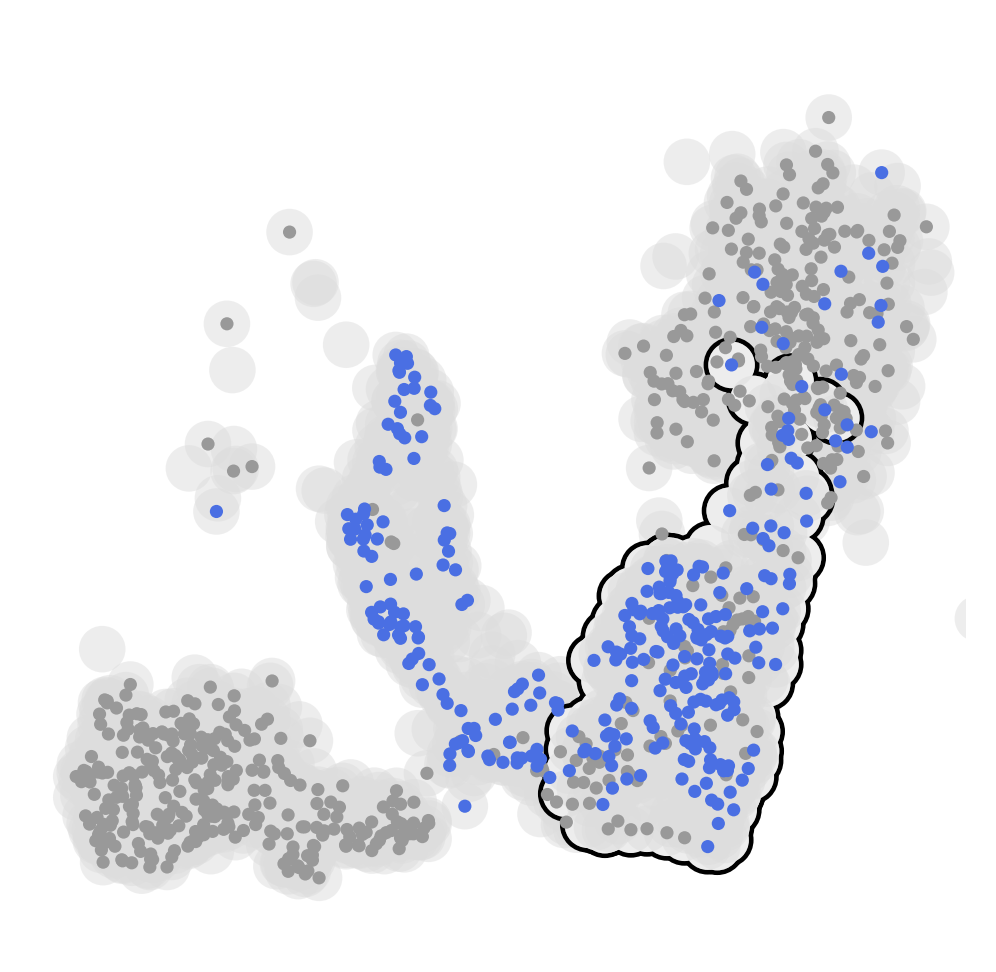

In [137]:
fig, ax = plt.subplots(figsize=(4, 4))

adata_draw = adata_control[adata_control.obs.celltype_NC_l2.isin([
    "Autonomic glia",
    "SCP",
    "Enteric neurons",
    "Chromaffin cells",
])]

sc.pl.umap(adata_draw, ax=ax, show=False, frameon=False, s=500, alpha=0.5, na_color="#DDDDDD")
sc.pl.umap(adata_draw[adata_draw.obs.celltype_NC_l2 == "Autonomic glia"], ax=ax, show=False, frameon=False, s=500, alpha=0.5,
           add_outline=True, outline_width=(0.1, 0), na_color="#DDDDDD")
sc.pl.umap(adata_draw[adata_draw.obs.clone_type.isin(["Glial bias", "Mixed", "Sympathetic bias"])], ax=ax, show=False, frameon=False, s=40, na_color="#999999")
sc.pl.umap(adata_draw[adata_draw.obs.clone_type == "Enteric bias"], ax=ax, show=False, frameon=False, s=40, na_color="#4a6fe3")

ax.set_ylim(-0, 10)
ax.set_xlim(-6, 10.5)

plt.savefig("figures/yet_another_NC_path.pdf", bbox_inches="tight")

In [138]:
adata_draw = adata_draw[adata_draw.obs.clone_type.isin(["Glial bias", "Sympathetic bias", "Enteric bias"])]
adata_draw = adata_draw[adata_draw.obs.celltype_NC_l2 == "Autonomic glia"]

sc.tl.rank_genes_groups(adata_draw, groupby="clone_type", method="t-test")

In [139]:
adata_draw_scaled = adata_draw.copy()
sc.pp.scale(adata_draw_scaled, max_value=10)

In [152]:
genes

names     scores  logfoldchanges         pvals     pvals_adj
0      Hand2os1  25.871550        5.749354  3.414954e-68  1.134004e-63
1          Hdnr  18.429800        6.491328  4.775547e-45  7.929079e-41
2         Plcb1  17.620079        4.312126  5.988639e-44  6.628825e-40
3         Hand2  14.169964        3.790195  6.600202e-32  5.479323e-28
4          Bnc2  11.742107        4.833794  2.913204e-25  1.934775e-21
...         ...        ...             ...           ...           ...
33202    mt-Nd4 -11.206293       -1.196830  1.169217e-19  2.588413e-16
33203    Cdkn1c -11.779402       -2.101962  1.365523e-22  5.668115e-19
33204    Pdzrn3 -11.811852       -2.077814  6.420126e-23  3.045616e-19
33205    Dpysl3 -12.315594       -2.411167  3.920159e-23  2.169612e-19
33206    mt-Co3 -12.559849       -1.253218  2.340727e-21  7.772852e-18

[33207 rows x 5 columns]

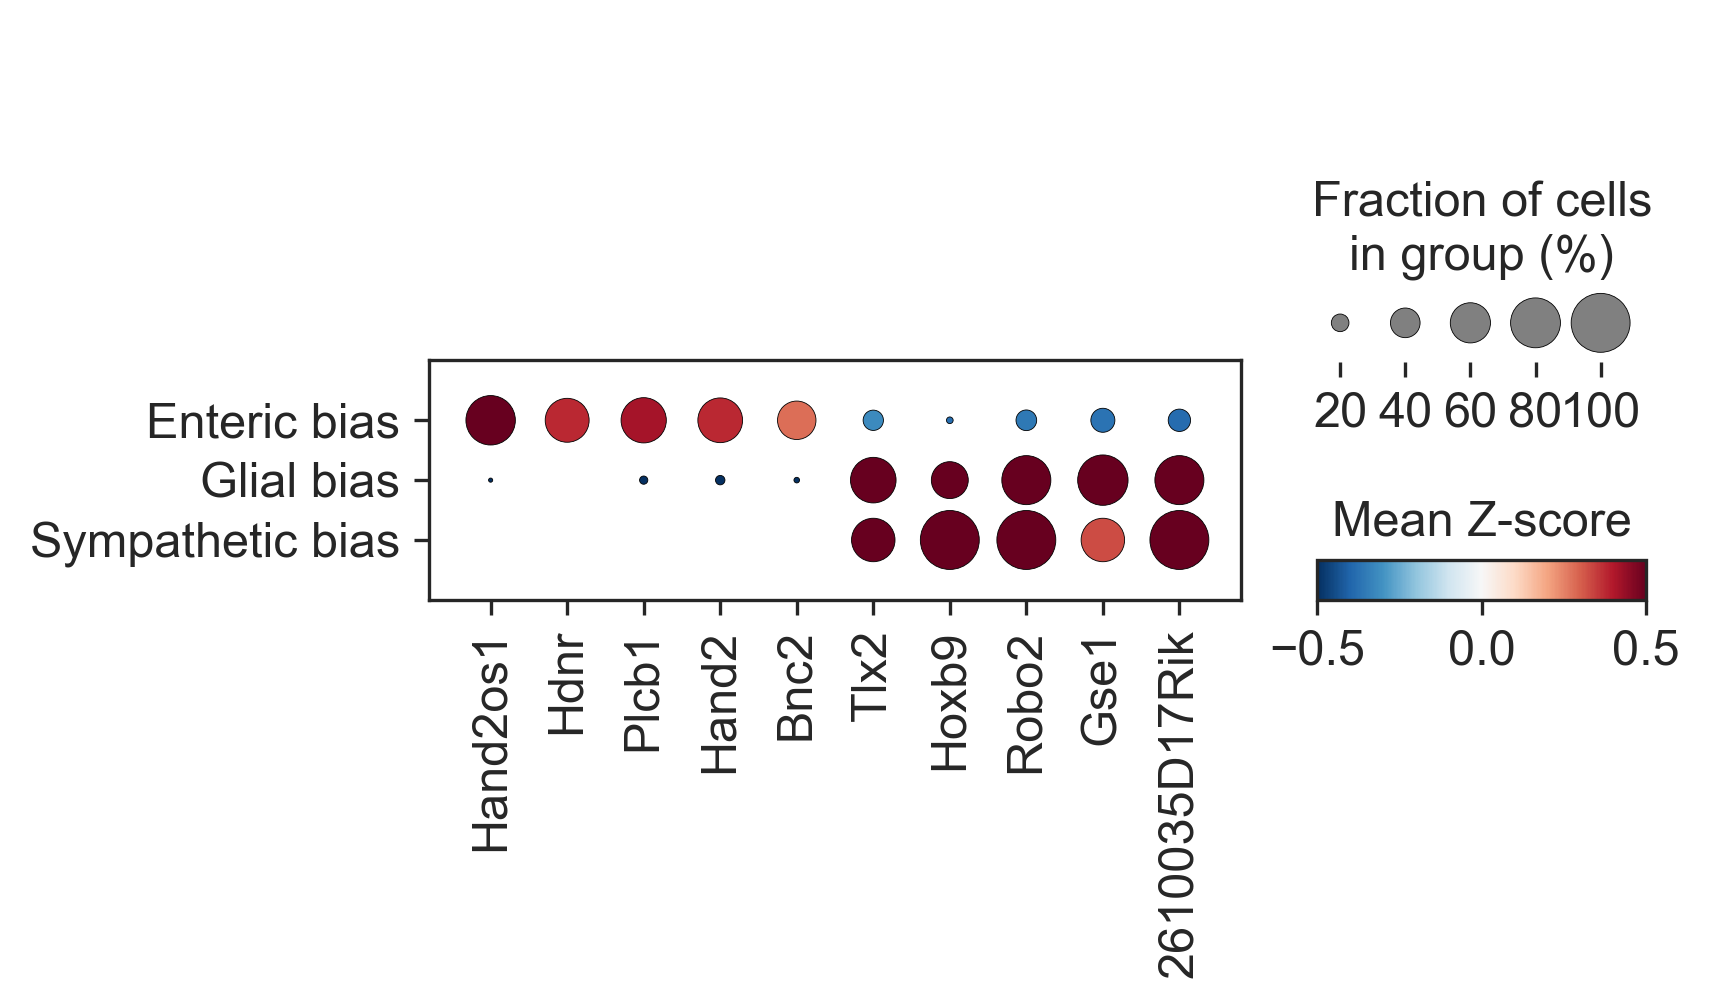

In [164]:
genes = sc.get.rank_genes_groups_df(adata_draw, group="Enteric bias")
genes = list(genes[
    (genes.logfoldchanges > 2.5) &
    (genes.pvals_adj < 1e-5)
][:5].names) + list(genes[
    (genes.logfoldchanges < -2.5) &
    (genes.pvals_adj < 1e-5)
][-5:].names)

sc.pl.dotplot(adata_draw_scaled, var_names=genes, groupby="clone_type", cmap="RdBu_r", vmin=-0.5, vmax=0.5,
              colorbar_title="Mean Z-score", save="clone_type_markers.pdf", swap_axes=False)

In [169]:
adata_NC.uns["log1p"]["base"] = None

In [170]:
sc.tl.rank_genes_groups(adata_NC, groupby="celltype_NC_l2")

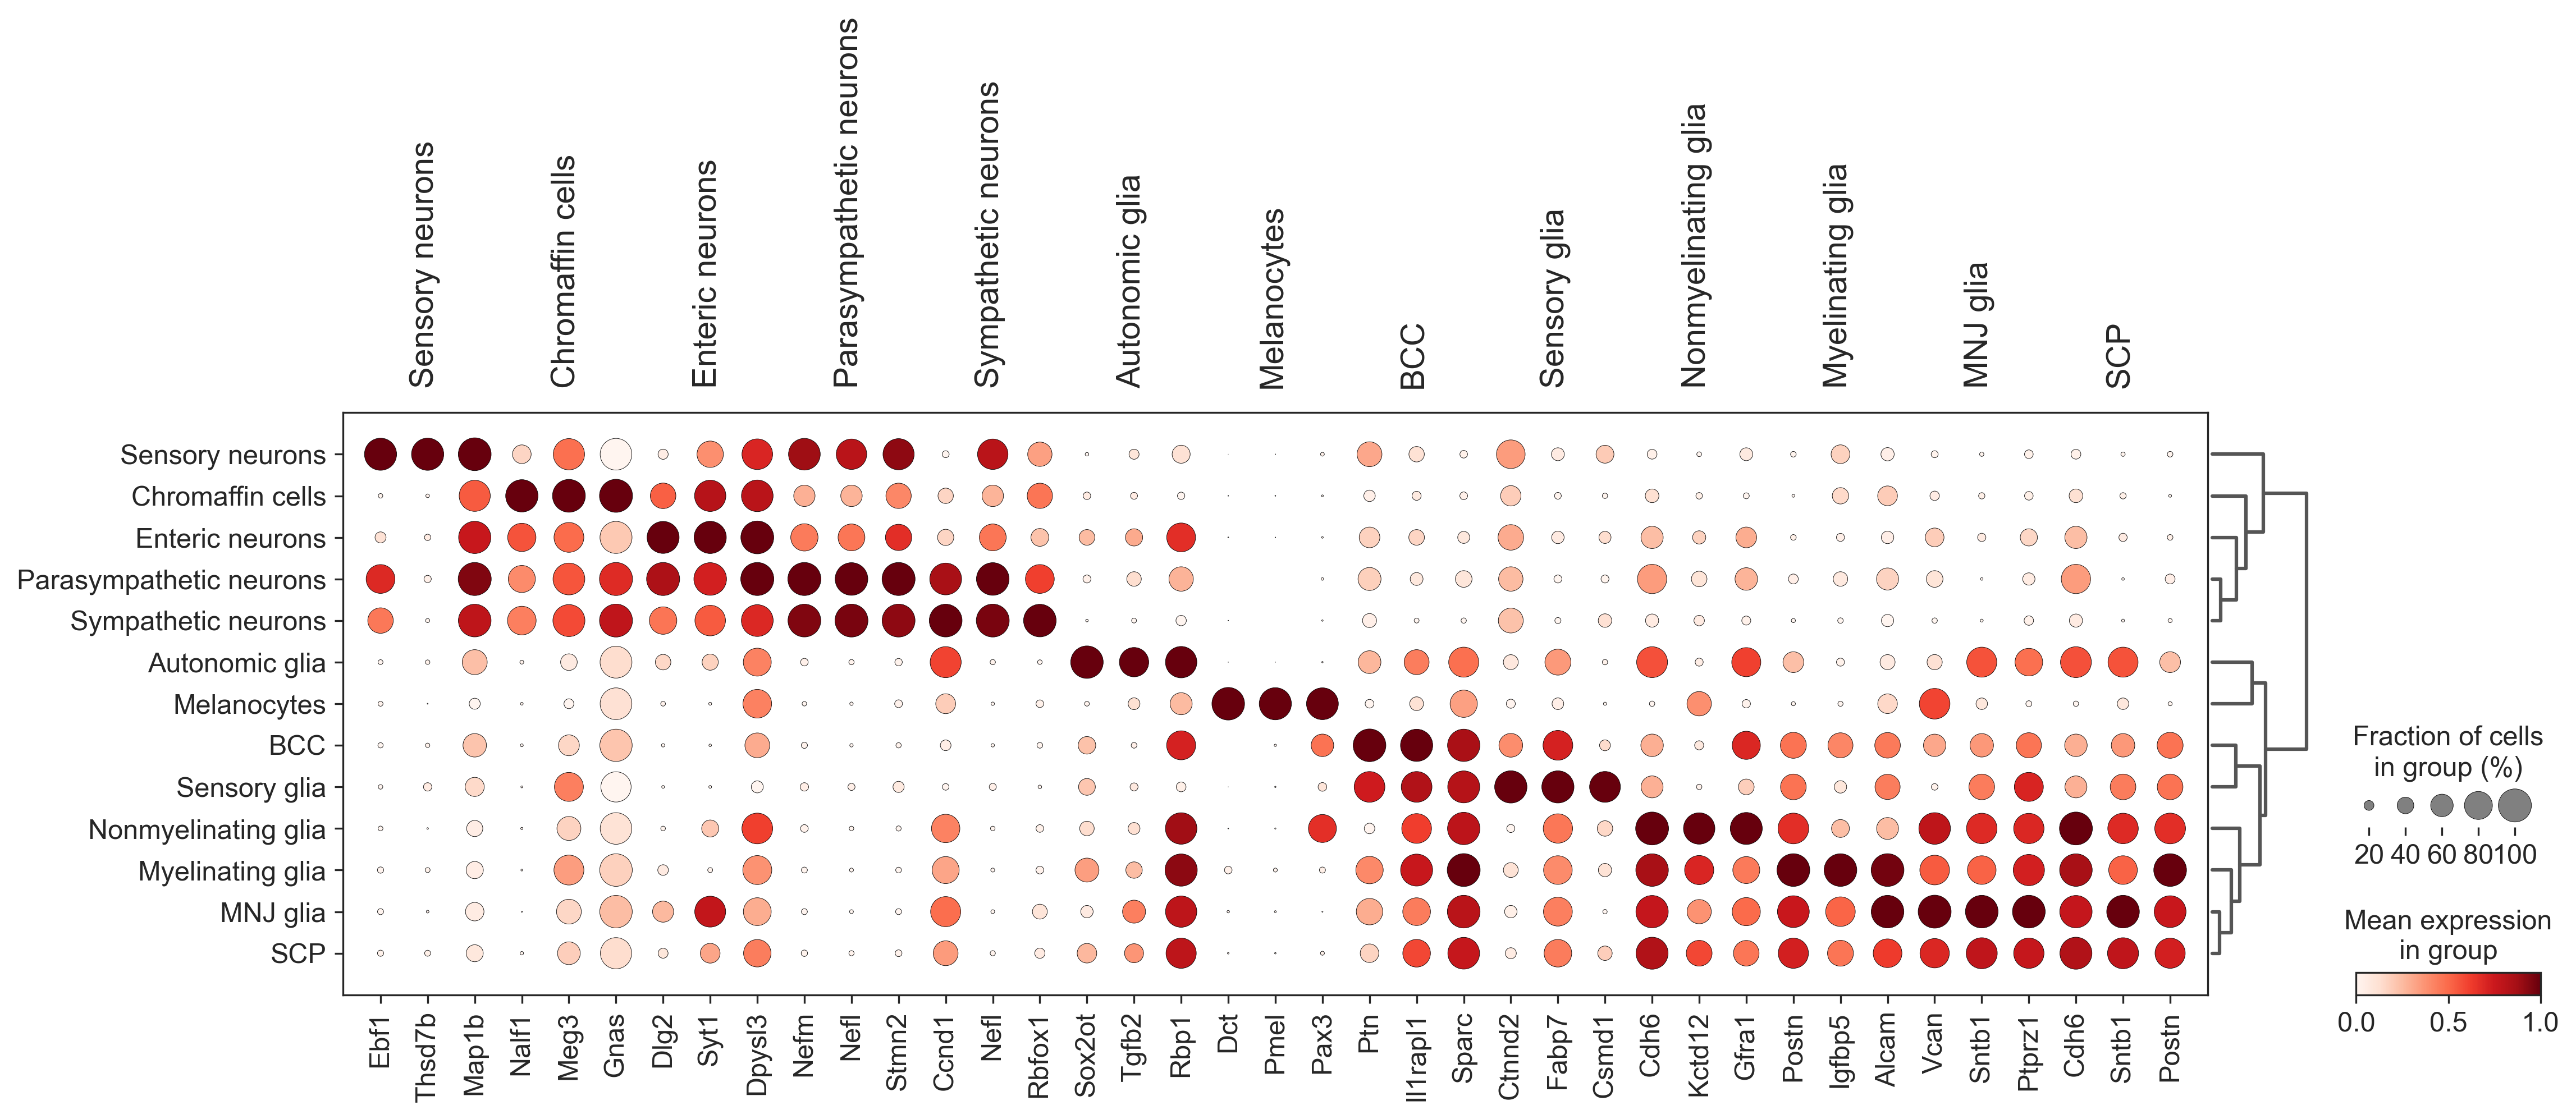

In [176]:
sc.pl.rank_genes_groups_dotplot(adata_NC, min_logfoldchange=2, n_genes=3, standard_scale="var", save="NC_markers.pdf")